In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ML libraries
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator, ClassifierMixin, clone
from xgboost import XGBClassifier
import lightgbm as lgb

# For imbalance handling
from imblearn.over_sampling import SMOTE

In [3]:
from scipy.stats import ttest_ind

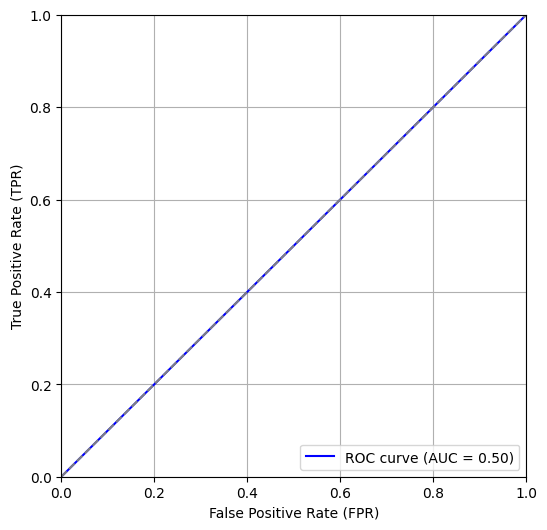

,Порог,TPR,FPR
0,inf,0.0,0.0
1,1.0,1.0,1.0


In [54]:
y_true = [1] * 90 + [0] * 10
y_scores = [1] * 100
roc_auc_score(y_true, y_scores)
# Расчет ROC-кривой
fpr, tpr, thresholds = roc_curve(y_true, y_scores)

# Расчет ROC-AUC
roc_auc = roc_auc_score(y_true, y_scores)

# Визуализация
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
# plt.title('ROC-кривая на примере с пятью объектами')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Выводим подробные данные по точкам ROC-кривой
roc_data = {
    "Порог": thresholds,
    "TPR": tpr,
    "FPR": fpr
}

# Формируем DataFrame для удобного отображения
pd.DataFrame(roc_data)

In [4]:
# Load the dataset
df = pd.read_csv('./data/rees46_churn_data.csv', index_col=0)

In [5]:
time_steps = sorted(list(df.time_step.drop_duplicates()), reverse = True)

In [6]:
df = df.drop('row_id', axis=1)

columns = list(df.columns)

In [7]:
untouchable_cols = [
    'user_id', 
    'target_event',
    'target_revenue',
    'target_customer_value',
    'time_step',
    'target_customer_value_lag1',
    'target_actual_profit'
]

In [ ]:
fig, ax = plt.subplots(1, 7, figsize=(25, 10), sharex=True, sharey=True)

for i in time_steps:
    tmp_df = pd.DataFrame(df[df.time_step == i]['target_event'])
    tmp_df.columns = ['Churn']
    ax[6 - i].title.set_text(f'Timestep {i}\nTotal users {len(tmp_df)}\nChurn share = {(len(tmp_df[tmp_df['Churn'] == 1]) / len(tmp_df) * 100):.2f}%')
    sns.countplot(x = 'Churn', data = tmp_df, ax=ax[6 - i], hue='Churn')
    ax[6 - i].set_xlabel('')
    ax[6 - i].set_ylabel('User count')


# Data proccessing

## Missing values

In [8]:
zero_fill_cols = ['purchase_revenue_sum', 'purchase_count_sum', 'cart_count_sum']
df[zero_fill_cols] = df[zero_fill_cols].fillna(0)

median_fill_cols = ['inter_session_time_mean', 'customer_value_month_ma3']
for col in median_fill_cols:
    df[col] = df[col].fillna(df[col].median())

## Аномалии и выбросы

In [9]:
columns

['user_id',
 'length_mean',
 'start_year_mean',
 'start_yearday_mean',
 'start_month_mean',
 'start_monthday_mean',
 'start_week_mean',
 'start_weekday_mean',
 'start_isweekend_mean',
 'start_hour_mean',
 'haspurchase_mean',
 'click_count_mean',
 'view_count_mean',
 'cart_count_mean',
 'purchase_count_mean',
 'time_to_click_mean',
 'time_to_view_mean',
 'time_to_cart_mean',
 'time_to_purchase_mean',
 'view_revenue_mean',
 'cart_revenue_mean',
 'purchase_revenue_mean',
 'time_to_click_revenue_mean',
 'time_to_view_revenue_mean',
 'time_to_cart_revenue_mean',
 'time_to_purchase_revenue_mean',
 'session_number_mean',
 'inter_session_time_mean',
 'session_recency_mean',
 'purchase_number_mean',
 'inter_purchase_time_mean',
 'purchase_recency_mean',
 'length_sum',
 'start_year_sum',
 'start_yearday_sum',
 'start_month_sum',
 'start_monthday_sum',
 'start_week_sum',
 'start_weekday_sum',
 'start_isweekend_sum',
 'start_hour_sum',
 'haspurchase_sum',
 'click_count_sum',
 'view_count_sum',
 'c

In [10]:
# Time columns
time_cols = []
for col in columns:
    if 'time' in col:
        time_cols.append(col)
df = df[(df[time_cols] >= 0).all(axis=1)]

In [11]:
# Target missunderstanding

churn_df = df[df.target_event == 1]
retention_df = df[df.target_event == 0]




In [12]:
event_cols = []
for col in columns:
    if ('purchase' in col or 'click' in col or 'view' in col) and 'mean' in col:
        event_cols.append(col)

In [13]:
event_cols

['haspurchase_mean',
 'click_count_mean',
 'view_count_mean',
 'purchase_count_mean',
 'time_to_click_mean',
 'time_to_view_mean',
 'time_to_purchase_mean',
 'view_revenue_mean',
 'purchase_revenue_mean',
 'time_to_click_revenue_mean',
 'time_to_view_revenue_mean',
 'time_to_purchase_revenue_mean',
 'purchase_number_mean',
 'inter_purchase_time_mean',
 'purchase_recency_mean']

In [14]:
pd.concat([churn_df[event_cols + ['target_event', 'time_step']][(churn_df.purchase_count_mean > 0) & (churn_df.user_id == 551695186)],
           retention_df[event_cols + ['target_event', 'time_step']][(retention_df.user_id == 551695186)]]).sort_values('time_step')

,haspurchase_mean,click_count_mean,view_count_mean,purchase_count_mean,time_to_click_mean,time_to_view_mean,time_to_purchase_mean,view_revenue_mean,purchase_revenue_mean,time_to_click_revenue_mean,time_to_view_revenue_mean,time_to_purchase_revenue_mean,purchase_number_mean,inter_purchase_time_mean,purchase_recency_mean,target_event,time_step
1,0.344828,6.172414,4.655172,0.517241,0.523721,0.725235,4.692431,1959.012586,374.06430,0.002761,0.003508,0.050686,10.5,8.723447,100.179020,1,0
4830,0.333333,6.333334,4.796296,0.518518,0.537019,0.740795,5.136960,2023.405185,372.53445,0.002874,0.003659,0.056217,9.5,7.761834,81.182770,0,1
25384,0.347826,6.304348,4.804348,0.500000,0.540535,0.739640,5.060069,2069.257174,306.10870,0.002379,0.003060,0.014586,8.5,7.244138,60.572590,0,2
22115,0.342105,6.289473,4.894737,0.500000,0.591961,0.809776,5.318803,2149.930789,344.86554,0.002422,0.003161,0.013244,7.0,7.734444,42.182915,0,3
97391,0.250000,6.350000,5.300000,0.350000,0.830257,1.083757,9.290000,2894.188500,222.26900,0.003384,0.004154,0.024655,3.0,5.981846,58.682552,0,4
43101,0.454545,7.909091,6.636363,0.636364,1.000299,1.385796,9.290000,4125.344545,404.12546,0.002875,0.004020,0.024655,3.0,5.981846,30.682566,1,5
15735,1.000000,9.666667,7.666666,1.333333,0.453889,0.631481,3.025000,4980.840000,865.44000,0.004399,0.005962,0.018347,2.0,0.007622,9.997126,0,6


In [15]:
retention_df[event_cols + ['target_event', 'time_step']][(retention_df.user_id == 551695186)]

,haspurchase_mean,click_count_mean,view_count_mean,purchase_count_mean,time_to_click_mean,time_to_view_mean,time_to_purchase_mean,view_revenue_mean,purchase_revenue_mean,time_to_click_revenue_mean,time_to_view_revenue_mean,time_to_purchase_revenue_mean,purchase_number_mean,inter_purchase_time_mean,purchase_recency_mean,target_event,time_step
4830,0.333333,6.333334,4.796296,0.518518,0.537019,0.740795,5.136960,2023.405185,372.53445,0.002874,0.003659,0.056217,9.5,7.761834,81.182770,0,1
15735,1.000000,9.666667,7.666666,1.333333,0.453889,0.631481,3.025000,4980.840000,865.44000,0.004399,0.005962,0.018347,2.0,0.007622,9.997126,0,6
22115,0.342105,6.289473,4.894737,0.500000,0.591961,0.809776,5.318803,2149.930789,344.86554,0.002422,0.003161,0.013244,7.0,7.734444,42.182915,0,3
25384,0.347826,6.304348,4.804348,0.500000,0.540535,0.739640,5.060069,2069.257174,306.10870,0.002379,0.003060,0.014586,8.5,7.244138,60.572590,0,2
97391,0.250000,6.350000,5.300000,0.350000,0.830257,1.083757,9.290000,2894.188500,222.26900,0.003384,0.004154,0.024655,3.0,5.981846,58.682552,0,4


In [16]:
def right_target(row):
    user_id = row['user_id']
    time_step = row['time_step']
    churn = row['target_event']
    if churn:
        is_not_churn_later = (df[(df.user_id == user_id) & (df.time_step < time_step)]['target_event'] == 0).any()
        return 0 if is_not_churn_later else churn
    return churn


df_with_right_taget = df.copy()
df_with_right_taget['target_event'] = df_with_right_taget.apply(right_target, axis=1)

In [17]:
df_with_right_taget

,user_id,length_mean,start_year_mean,start_yearday_mean,start_month_mean,start_monthday_mean,start_week_mean,start_weekday_mean,start_isweekend_mean,start_hour_mean,...,purchase_latent_factor14,purchase_latent_factor15,purchase_latent_factor16,purchase_latent_factor17,target_event,target_revenue,target_customer_value,time_step,target_customer_value_lag1,target_actual_profit
0,522576412,10133.678750,2019.3250,241.65000,8.400000,16.875000,33.825000,4.225000,0.300000,15.725000,...,0.633005,0.063525,0.000000,0.000000e+00,0.0,3403.83,171.760358,0,90.148425,-13.279611
1,551695186,5.359195,2019.3620,222.05173,7.827586,14.655172,31.448277,4.034483,0.258621,15.620689,...,0.395069,0.267275,0.000000,0.000000e+00,1.0,0.00,387.102758,0,445.168171,3.592337
2,561472000,4.885714,2019.0000,297.54285,10.114285,21.000000,43.142857,2.942857,0.285714,14.171429,...,0.000000,0.000000,0.000000,0.000000e+00,1.0,0.00,347.097991,0,399.162689,3.216008
3,585643355,4175.082759,2019.8966,106.00000,3.931035,17.655172,15.896552,3.655172,0.206897,13.620689,...,0.165644,0.000000,0.165603,2.638056e-01,0.0,937.86,279.270244,0,321.607950,-13.185855
4,520792937,3.325601,2019.3196,212.86598,7.556701,13.711340,30.989690,3.958763,0.350515,13.092784,...,0.000000,0.000000,0.048937,0.000000e+00,1.0,0.00,91.360471,0,105.064542,0.732248
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112605,519232309,4.961111,2019.0000,277.66666,10.000000,4.666666,40.000000,2.000000,0.666667,19.000000,...,0.370003,0.000000,0.000000,2.846144e-02,0.0,6122.06,781.199483,6,0.000000,-13.361978
112606,519877091,9.433333,2019.0000,280.00000,10.000000,7.000000,41.000000,2.000000,0.000000,11.000000,...,0.000000,0.000000,0.096286,0.000000e+00,0.0,44.31,7.504752,6,0.000000,-13.204804
112607,522717744,4.493333,2019.0000,282.20000,10.000000,9.200000,40.800000,5.600000,0.000000,17.600000,...,0.000000,0.000000,0.000000,7.136990e-10,0.0,1437.04,186.782840,6,0.000000,-13.019538
112608,545552285,4.537121,2019.0000,281.22726,10.000000,8.227273,40.863636,3.863636,0.181818,16.909090,...,0.000000,0.000000,0.000000,0.000000e+00,0.0,11309.77,1097.905697,6,0.000000,-13.207042


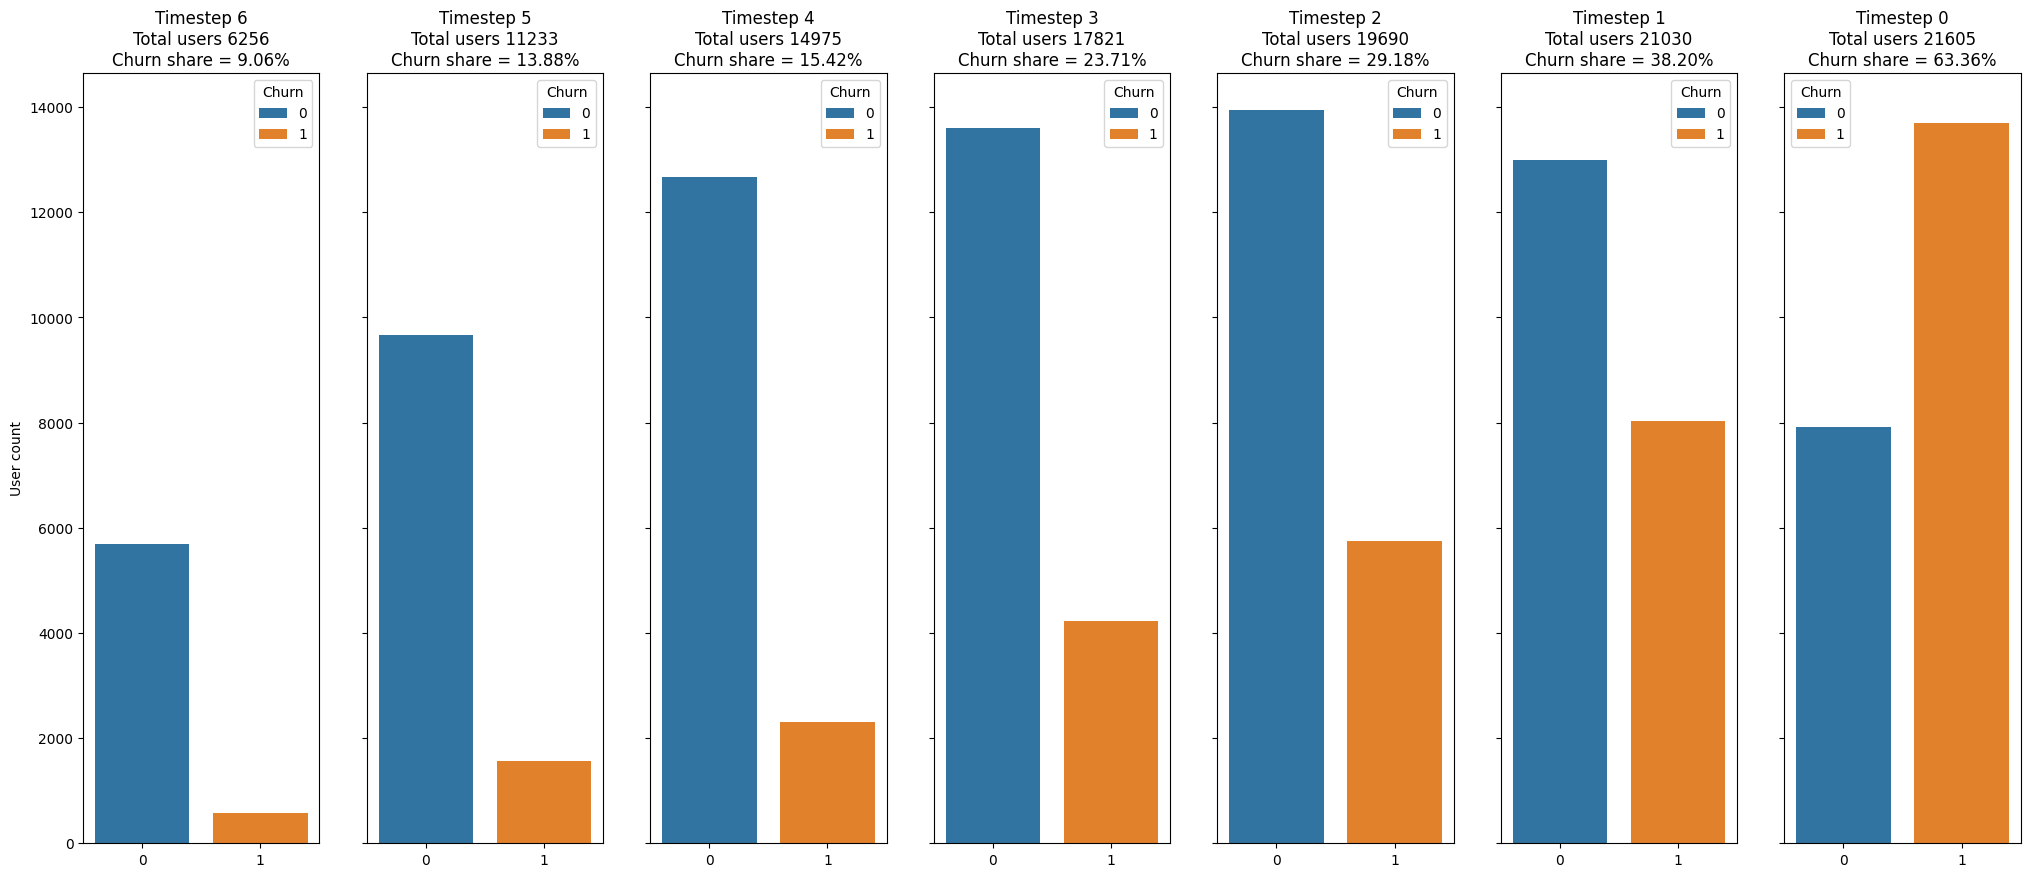

In [18]:
fig, ax = plt.subplots(1, 7, figsize=(25, 10), sharex=True, sharey=True)

for i in time_steps:
    tmp_df = pd.DataFrame(df[df.time_step == i]['target_event'])
    tmp_df.columns = ['Churn']
    ax[6 - i].title.set_text(f'Timestep {i}\nTotal users {len(tmp_df)}\nChurn share = {(len(tmp_df[tmp_df['Churn'] == 1]) / len(tmp_df) * 100):.2f}%')
    sns.countplot(x = 'Churn', data = tmp_df, ax=ax[6 - i], hue='Churn')
    ax[6 - i].set_xlabel('')
    ax[6 - i].set_ylabel('User count')


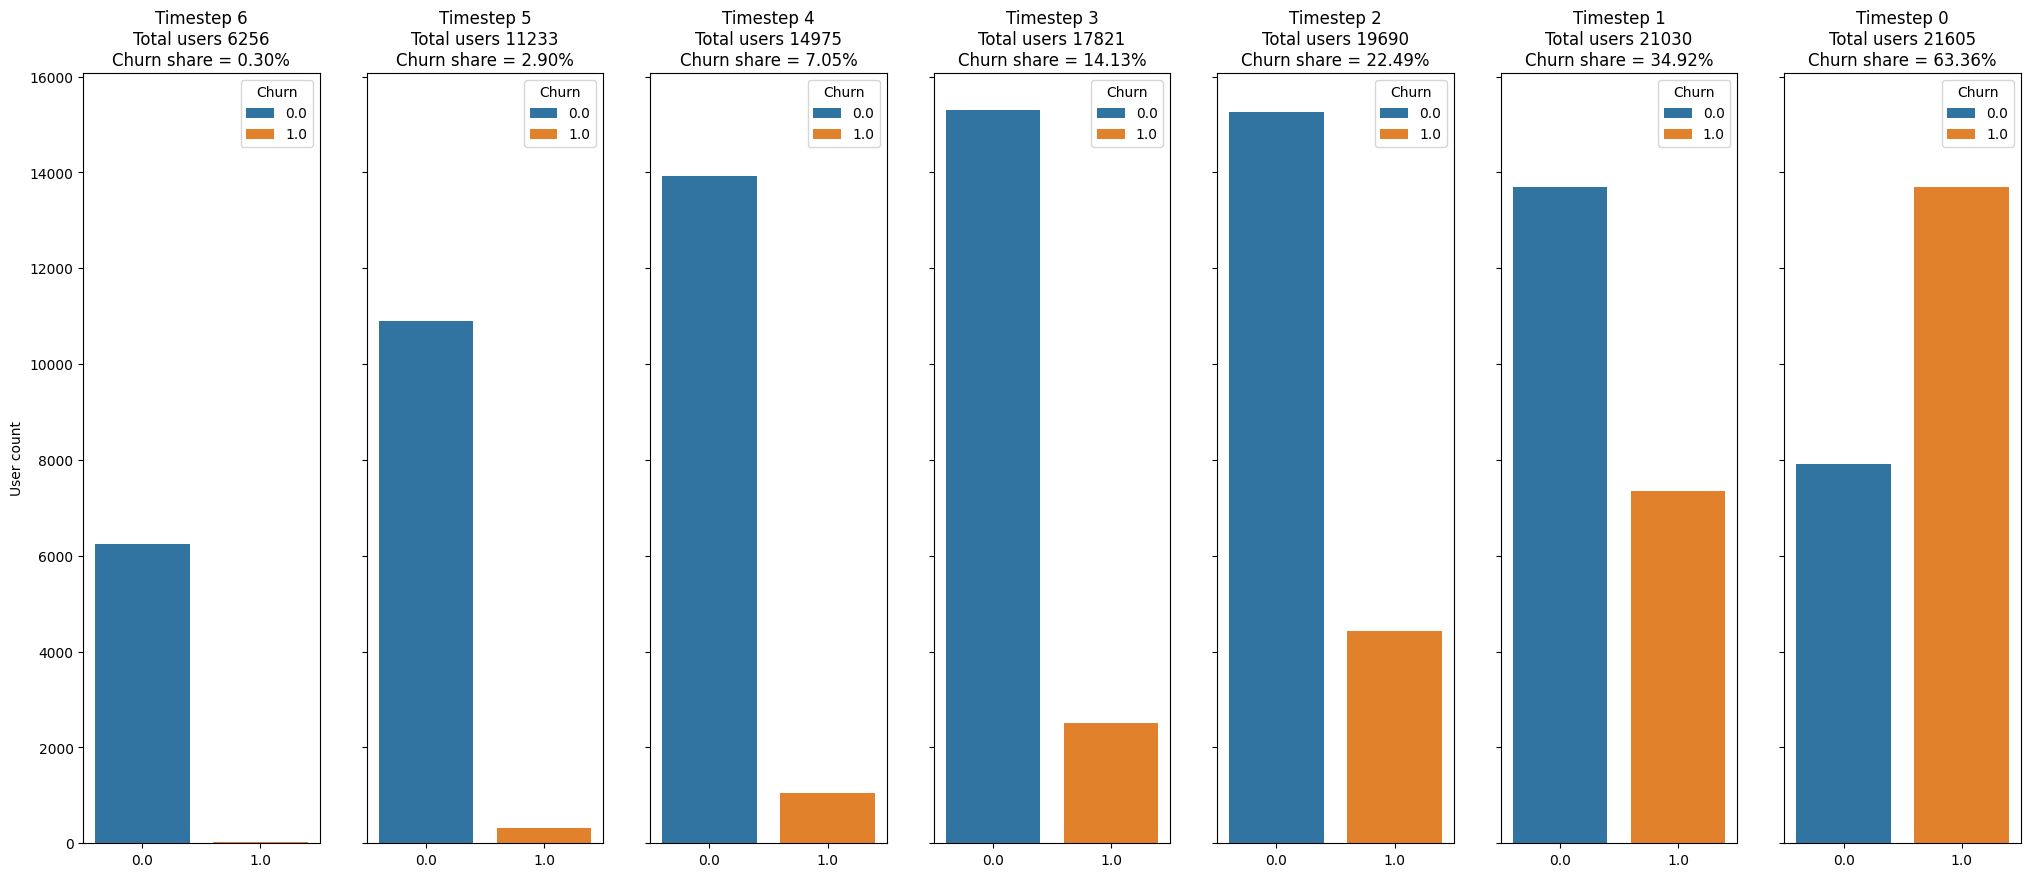

In [20]:
fig, ax = plt.subplots(1, 7, figsize=(25, 10), sharex=True, sharey=True)

for i in time_steps:
    tmp_df = pd.DataFrame(df_with_right_taget[df_with_right_taget.time_step == i]['target_event'])
    tmp_df.columns = ['Churn']
    ax[6 - i].title.set_text(f'Timestep {i}\nTotal users {len(tmp_df)}\nChurn share = {(len(tmp_df[tmp_df['Churn'] == 1]) / len(tmp_df) * 100):.2f}%')
    sns.countplot(x = 'Churn', data = tmp_df, ax=ax[6 - i], hue='Churn')
    ax[6 - i].set_xlabel('')
    ax[6 - i].set_ylabel('User count')


In [21]:
# def left_target(row):
#     user_id = row['user_id']
#     time_step = row['time_step']
#     churn = row['target_event']
#     if not churn:
#         is_churn_before = (df[(df.user_id == user_id) & (df.time_step > time_step)]['target_event'] == 1).any()
#         return 1 if is_churn_before else churn
#     return churn


# df_with_left_taget = df.copy()
# df_with_left_taget['target_event'] = df_with_left_taget.apply(left_target, axis=1)

In [22]:
# fig, ax = plt.subplots(1, 7, figsize=(25, 10), sharex=True, sharey=True)

# for i in time_steps:
#     tmp_df = pd.DataFrame(df_with_left_taget[df_with_left_taget.time_step == i]['target_event'])
#     tmp_df.columns = ['Churn']
#     ax[6 - i].title.set_text(f'Timestep {i}\nTotal users {len(tmp_df)}\nChurn share = {(len(tmp_df[tmp_df['Churn'] == 1]) / len(tmp_df) * 100):.2f}%')
#     sns.countplot(x = 'Churn', data = tmp_df, ax=ax[6 - i], hue='Churn')
#     ax[6 - i].set_xlabel('')
#     ax[6 - i].set_ylabel('User count')


In [45]:
df = df_with_right_taget

In [46]:
# Duplicates
print(df.drop_duplicates(subset=['user_id', 'time_step']).shape)
df.shape

(112610, 275)


(112610, 275)

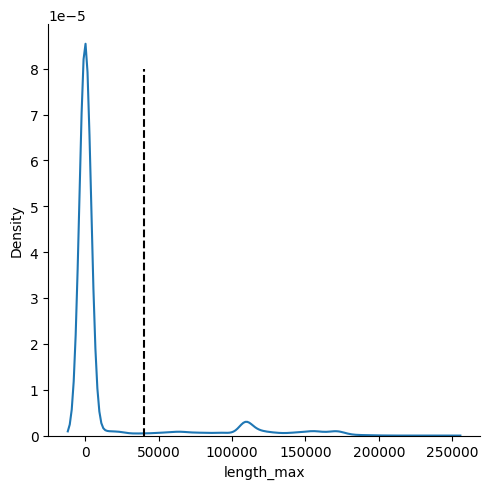

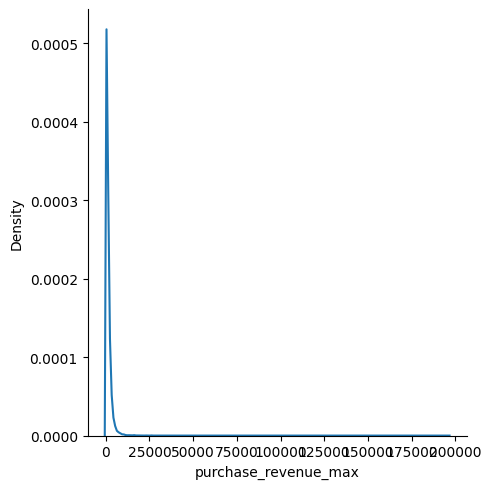

In [47]:
# Удаление аномальных значений
# df = df[df['inter_session_time_min'] >= 0]
# df = df[df['purchase_revenue_sum'] >= 0]

sns.displot(df.length_max, kind="kde")#.quantile(0.85) / 60#.describe()
# ~one month
q = 60*24*7*4
plt.plot([q, q], [0, 8e-5], 'k--')
sns.displot(df.purchase_revenue_max, kind="kde")#.quantile(0.85) / 60#.describe()

In [48]:
# Filter by session length
print(df[df.length_max < q].shape)
df.shape
df = df[df.length_max <= q]

(98181, 275)


In [49]:
retention = {}
for i in time_steps:
    time_step_users = df[(df.time_step == i) & (~df.user_id.isin(df[df.time_step > i].user_id))].user_id
    i_ret = {}
    for j in range(i, min(time_steps) - 1, -1):
        i_ret[j] = len(df[(df.time_step == j) & (df.user_id.isin(time_step_users))].user_id)
    retention[i] = i_ret
retention

{6: {6: 6256, 5: 6256, 4: 6253, 3: 6252, 2: 5058, 1: 4240, 0: 4200},
 5: {5: 4977, 4: 4977, 3: 4976, 2: 4011, 1: 3315, 0: 3288},
 4: {4: 3742, 3: 3742, 2: 3014, 1: 2576, 0: 2563},
 3: {3: 2846, 2: 2486, 1: 2221, 0: 2215},
 2: {2: 1850, 1: 1826, 0: 1823},
 1: {1: 1324, 0: 1324},
 0: {0: 570}}

In [50]:
retention = {}
for i in time_steps:
    time_step_users = df[(df.time_step == i) & (~df.user_id.isin(df[df.time_step > i].user_id))].user_id
    i_ret = {}
    for j in range(i, min(time_steps) - 1, -1):
        i_ret[j] = len(df[(df.time_step == j) & (df.user_id.isin(time_step_users))].user_id)
    retention[i] = i_ret
retention

{6: {6: 6256, 5: 6256, 4: 6253, 3: 6252, 2: 5058, 1: 4240, 0: 4200},
 5: {5: 4977, 4: 4977, 3: 4976, 2: 4011, 1: 3315, 0: 3288},
 4: {4: 3742, 3: 3742, 2: 3014, 1: 2576, 0: 2563},
 3: {3: 2846, 2: 2486, 1: 2221, 0: 2215},
 2: {2: 1850, 1: 1826, 0: 1823},
 1: {1: 1324, 0: 1324},
 0: {0: 570}}

In [51]:
# Conversion must be in [0, 1]
df = df[~(df['purchase_count_sum'] / df['view_count_sum'] > 1)]

In [52]:
retention = {}
for i in time_steps:
    time_step_users = df[(df.time_step == i) & (~df.user_id.isin(df[df.time_step > i].user_id))].user_id
    i_ret = {}
    for j in range(i, min(time_steps) - 1, -1):
        i_ret[j] = len(df[(df.time_step == j) & (df.user_id.isin(time_step_users))].user_id)
    retention[i] = i_ret
retention

{6: {6: 6255, 5: 6255, 4: 6252, 3: 6251, 2: 5057, 1: 4239, 0: 4199},
 5: {5: 4977, 4: 4977, 3: 4976, 2: 4011, 1: 3315, 0: 3288},
 4: {4: 3743, 3: 3743, 2: 3015, 1: 2577, 0: 2564},
 3: {3: 2846, 2: 2486, 1: 2221, 0: 2215},
 2: {2: 1849, 1: 1825, 0: 1822},
 1: {1: 1281, 0: 1281},
 0: {0: 602}}

## Data engineering

In [63]:
# Коэффициент конверсии
df['conversion_rate'] = df['purchase_count_sum'] / df['view_count_sum']
df['conversion_rate'] = df['conversion_rate'].replace([np.inf, -np.inf], np.nan)
df['conversion_rate'] = df['conversion_rate'].fillna(0)


In [64]:
# Средняя стоимость заказа (AOV)
df['avg_order_value'] = df['purchase_revenue_sum'] / df['purchase_count_sum']
df['avg_order_value'] = df['avg_order_value'].replace([np.inf, -np.inf], np.nan)
df['avg_order_value'] = df['avg_order_value'].fillna(0)


## Нормализация и масштабирование

In [65]:
# df_saving = df.copy()
# df = df_saving.copy()

In [66]:
log_cols = []
c = 0
for col in columns:
    if col in untouchable_cols:
        continue
    q2 = df[col].quantile(0.5)
    if q2 == 0:
        continue
    m = df[col].mean()
    # print(col, len(df[(df[col] < lower_outlier_threshold) | (df[col] > upper_outlier_threshold)]))
    if  (m > q2 * 4) or (q2 > m * 4):
        print(col, q2, m)
        c += 1
        df[col] = (df[col] + 1).apply(np.log10)
        log_cols.append(col)
c

length_mean 3.615752710592161 32.3887976996944
time_to_click_mean 0.50688851 5.0752660656977655
time_to_view_mean 0.7668707992780122 11.705577911438258
time_to_cart_mean 2.8686805555555557 247.0077462600619
time_to_purchase_mean 3.285072463768116 38.33245132197128
time_to_click_revenue_mean 0.0038911072 0.04891984392005442
time_to_view_revenue_mean 0.0057969805 0.10753321491792668
time_to_cart_revenue_mean 0.021421889 4.790359892515816
time_to_purchase_revenue_mean 0.0242649245 0.4108881340410113
length_sum 130.5166666666667 1377.2995225331729
time_to_click_sum 18.751872294372294 213.45589039067102
time_to_view_sum 29.214685866678767 461.35006078276194
time_to_cart_sum 55.12287581699346 4499.7045010618
time_to_purchase_sum 57.047916666666666 781.027997953834
time_to_click_revenue_sum 0.1355726770633435 2.239948425383849
time_to_view_revenue_sum 0.2034786516788244 4.635111870216652
time_to_cart_revenue_sum 0.38630931983094197 82.60172636839454
time_to_purchase_revenue_sum 0.388097274957

46

In [67]:
def level_feeding(value):
    if value > upper_outlier_threshold:
        return upper_outlier_threshold
    if value < lower_outlier_threshold:
        return lower_outlier_threshold
    return value
volatile_cols = []
for col in columns:
    if col in untouchable_cols:
        continue
    q3 = df[col].quantile(0.75)
    q2 = df[col].quantile(0.5)
    q1 = df[col].quantile(0.25)
    iqr = q3 - q1
    upper_outlier_threshold = q3 + 3 * iqr
    lower_outlier_threshold = q1 - 3 * iqr
    print(col, len(df[(df[col] < lower_outlier_threshold) | (df[col] > upper_outlier_threshold)]))
    df[col] = df[col].apply(level_feeding)


length_mean 3167
haspurchase_mean 0
click_count_mean 1166
view_count_mean 1380
cart_count_mean 627
purchase_count_mean 531
time_to_click_mean 4369
time_to_view_mean 4386
time_to_cart_mean 6852
time_to_purchase_mean 2695
view_revenue_mean 1220
cart_revenue_mean 2076
purchase_revenue_mean 2197
time_to_click_revenue_mean 5837
time_to_view_revenue_mean 5785
time_to_cart_revenue_mean 10470
time_to_purchase_revenue_mean 7357
session_number_mean 1681
inter_session_time_mean 3619
session_recency_mean 0
purchase_number_mean 1198
inter_purchase_time_mean 5681
purchase_recency_mean 0
length_sum 789
haspurchase_sum 1198
click_count_sum 2413
view_count_sum 3153
cart_count_sum 1351
purchase_count_sum 1691
time_to_click_sum 1998
time_to_view_sum 2272
time_to_cart_sum 3094
time_to_purchase_sum 1927
view_revenue_sum 3056
cart_revenue_sum 2952
purchase_revenue_sum 3178
time_to_click_revenue_sum 5021
time_to_view_revenue_sum 4287
time_to_cart_revenue_sum 6745
time_to_purchase_revenue_sum 3110
session_num

## Эксплораторный анализ

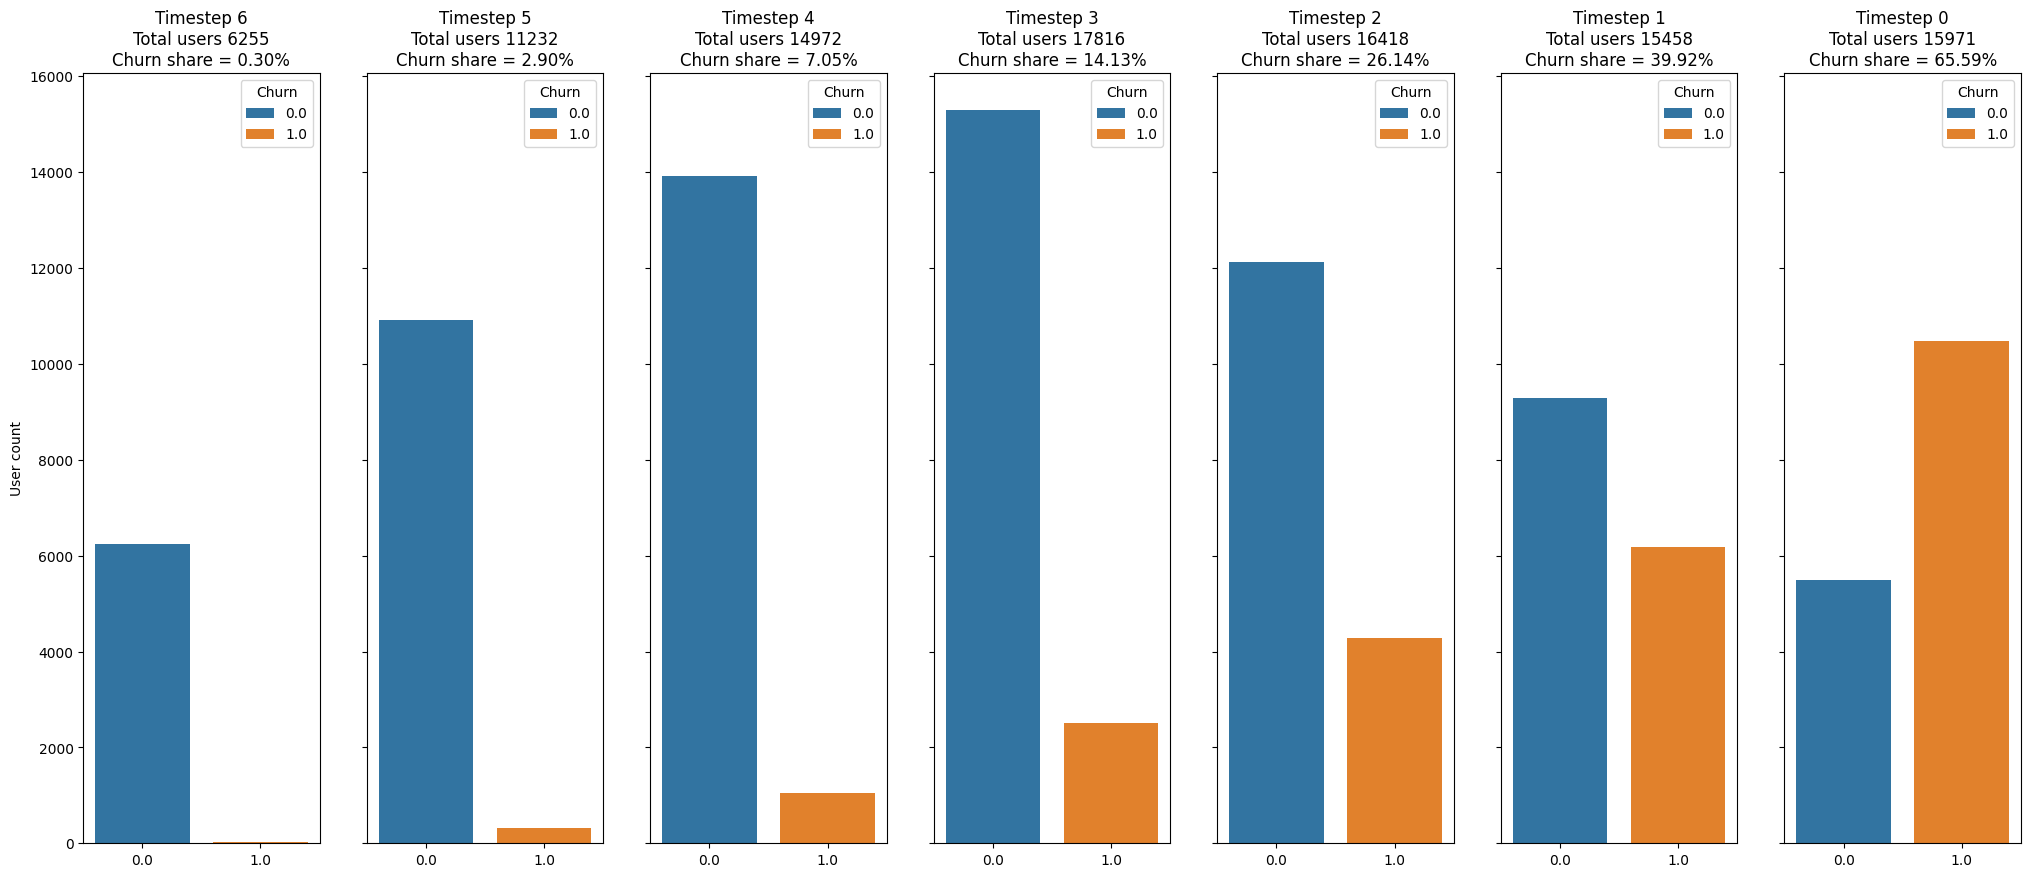

In [68]:
fig, ax = plt.subplots(1, 7, figsize=(25, 10), sharex=True, sharey=True)

for i in time_steps:
    tmp_df = pd.DataFrame(df[df.time_step == i]['target_event'])
    tmp_df.columns = ['Churn']
    ax[6 - i].title.set_text(f'Timestep {i}\nTotal users {len(tmp_df)}\nChurn share = {(len(tmp_df[tmp_df['Churn'] == 1]) / len(tmp_df) * 100):.2f}%')
    sns.countplot(x = 'Churn', data = tmp_df, ax=ax[6 - i], hue='Churn')
    ax[6 - i].set_xlabel('')
    ax[6 - i].set_ylabel('User count')


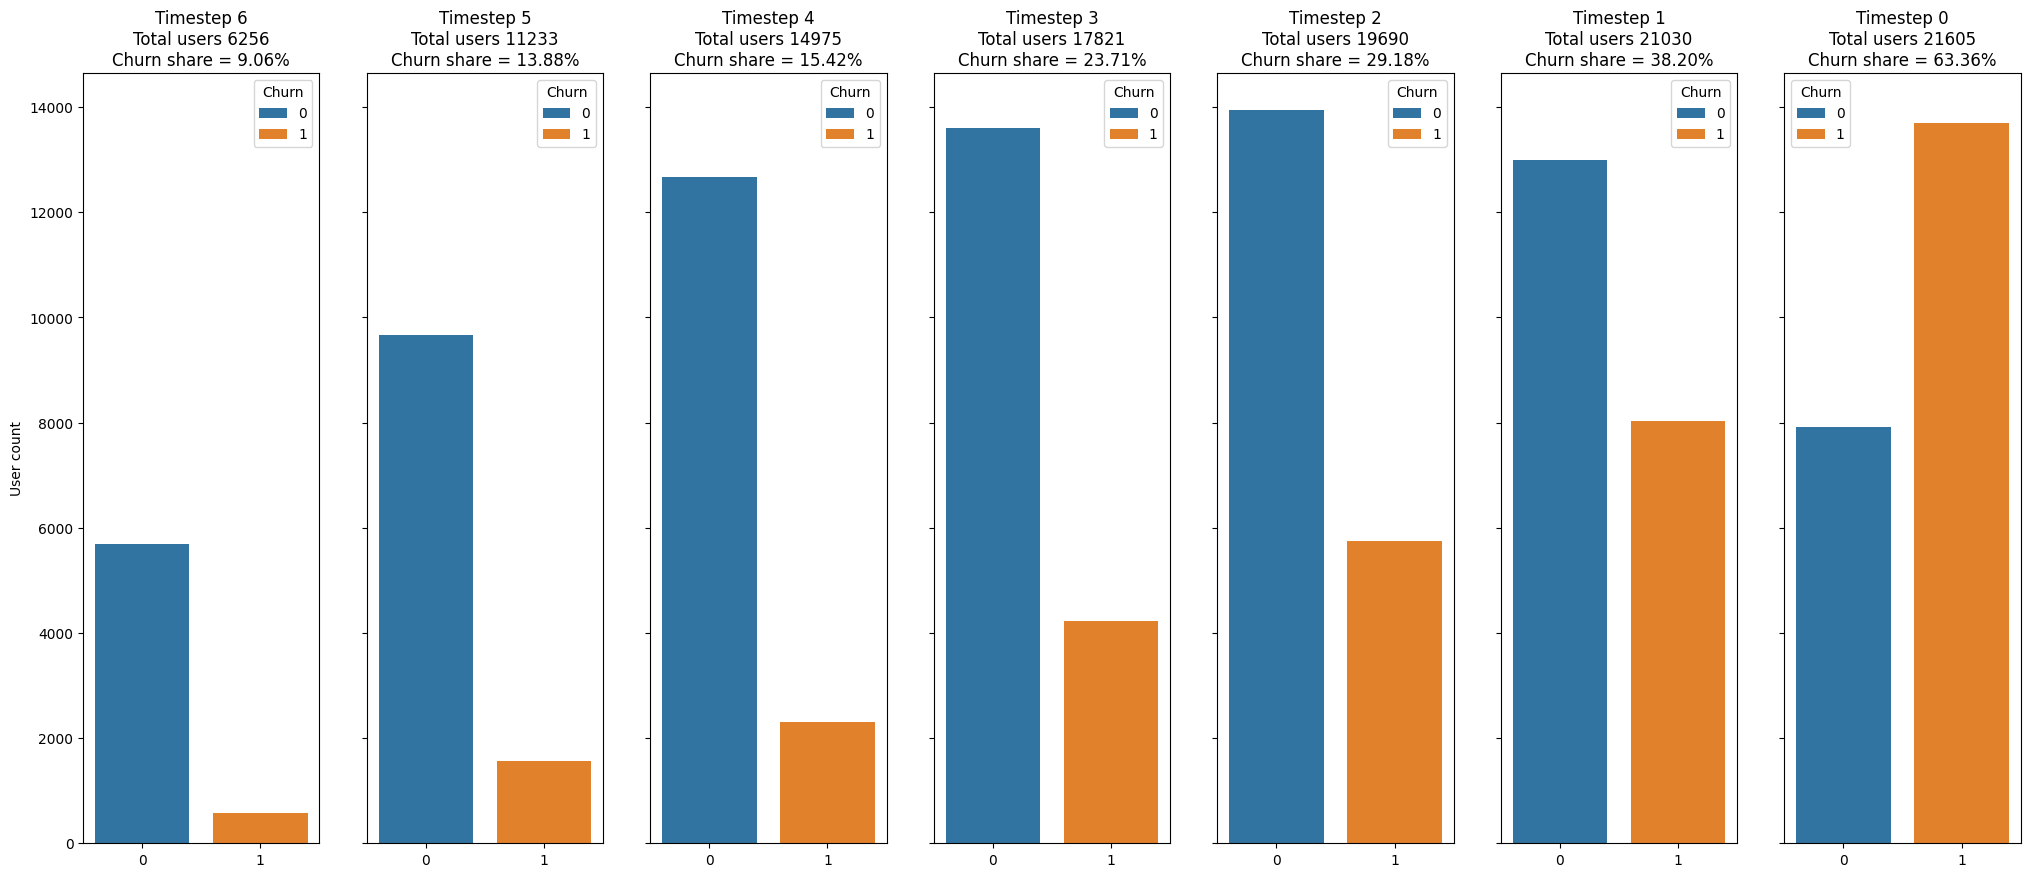

In [93]:
fig, ax = plt.subplots(1, 7, figsize=(25, 10), sharex=True, sharey=True)

for i in time_steps:
    tmp_df = pd.DataFrame(df[df.time_step == i]['target_event'])
    tmp_df.columns = ['Churn']
    ax[6 - i].title.set_text(f'Timestep {i}\nTotal users {len(tmp_df)}\nChurn share = {(len(tmp_df[tmp_df['Churn'] == 1]) / len(tmp_df) * 100):.2f}%')
    sns.countplot(x = 'Churn', data = tmp_df, ax=ax[6 - i], hue='Churn')
    ax[6 - i].set_xlabel('')
    ax[6 - i].set_ylabel('User count')


6
5
4
3
2
1
0


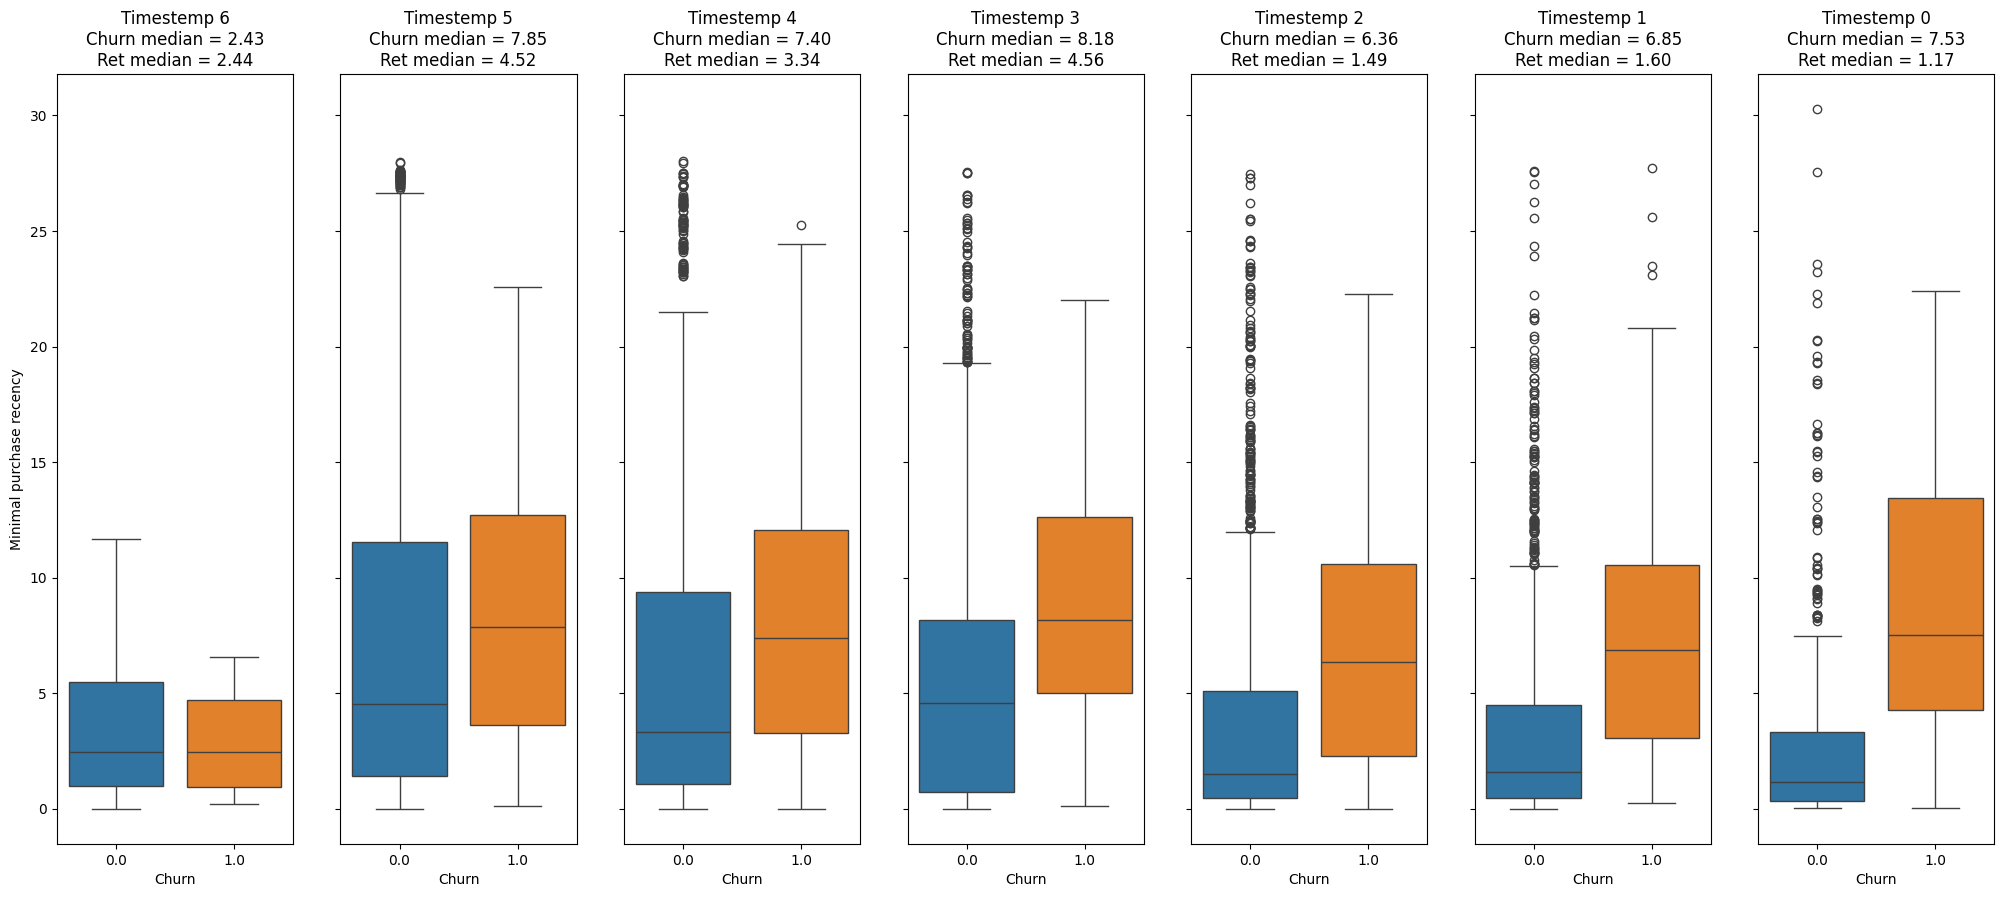

In [103]:
fig, ax = plt.subplots(1, 7, figsize=(25, 10), sharex=True, sharey=True)

for i in time_steps:
    print(i)
    prev_users = df[df.time_step > i].user_id
    tmp_df = df[(df.time_step == i) & (~df.user_id.isin(prev_users))][['target_event', 'purchase_recency_min']]
    # tmp_df = df[df.time_step == i][['target_event', 'purchase_recency_min']]
    tmp_df.columns = ['Churn', 'Minimal purchase recency']
    ax[(6 - i)].title.set_text(f'Timestemp {i}\nChurn median = {tmp_df[tmp_df.Churn == 1]['Minimal purchase recency'].median():.2f}\nRet median = {tmp_df[tmp_df.Churn == 0]['Minimal purchase recency'].median():.2f}')
    sns.boxplot(tmp_df, x='Churn', y='Minimal purchase recency', hue='Churn', ax=ax[(6 - i)], legend=False)
    # ax[4-i].set_xlabel('Churn')
    # ax[4-i].set_ylabel('Session recency')

    # plt.ylabel('Churn')




6
5
4
3
2
1
0


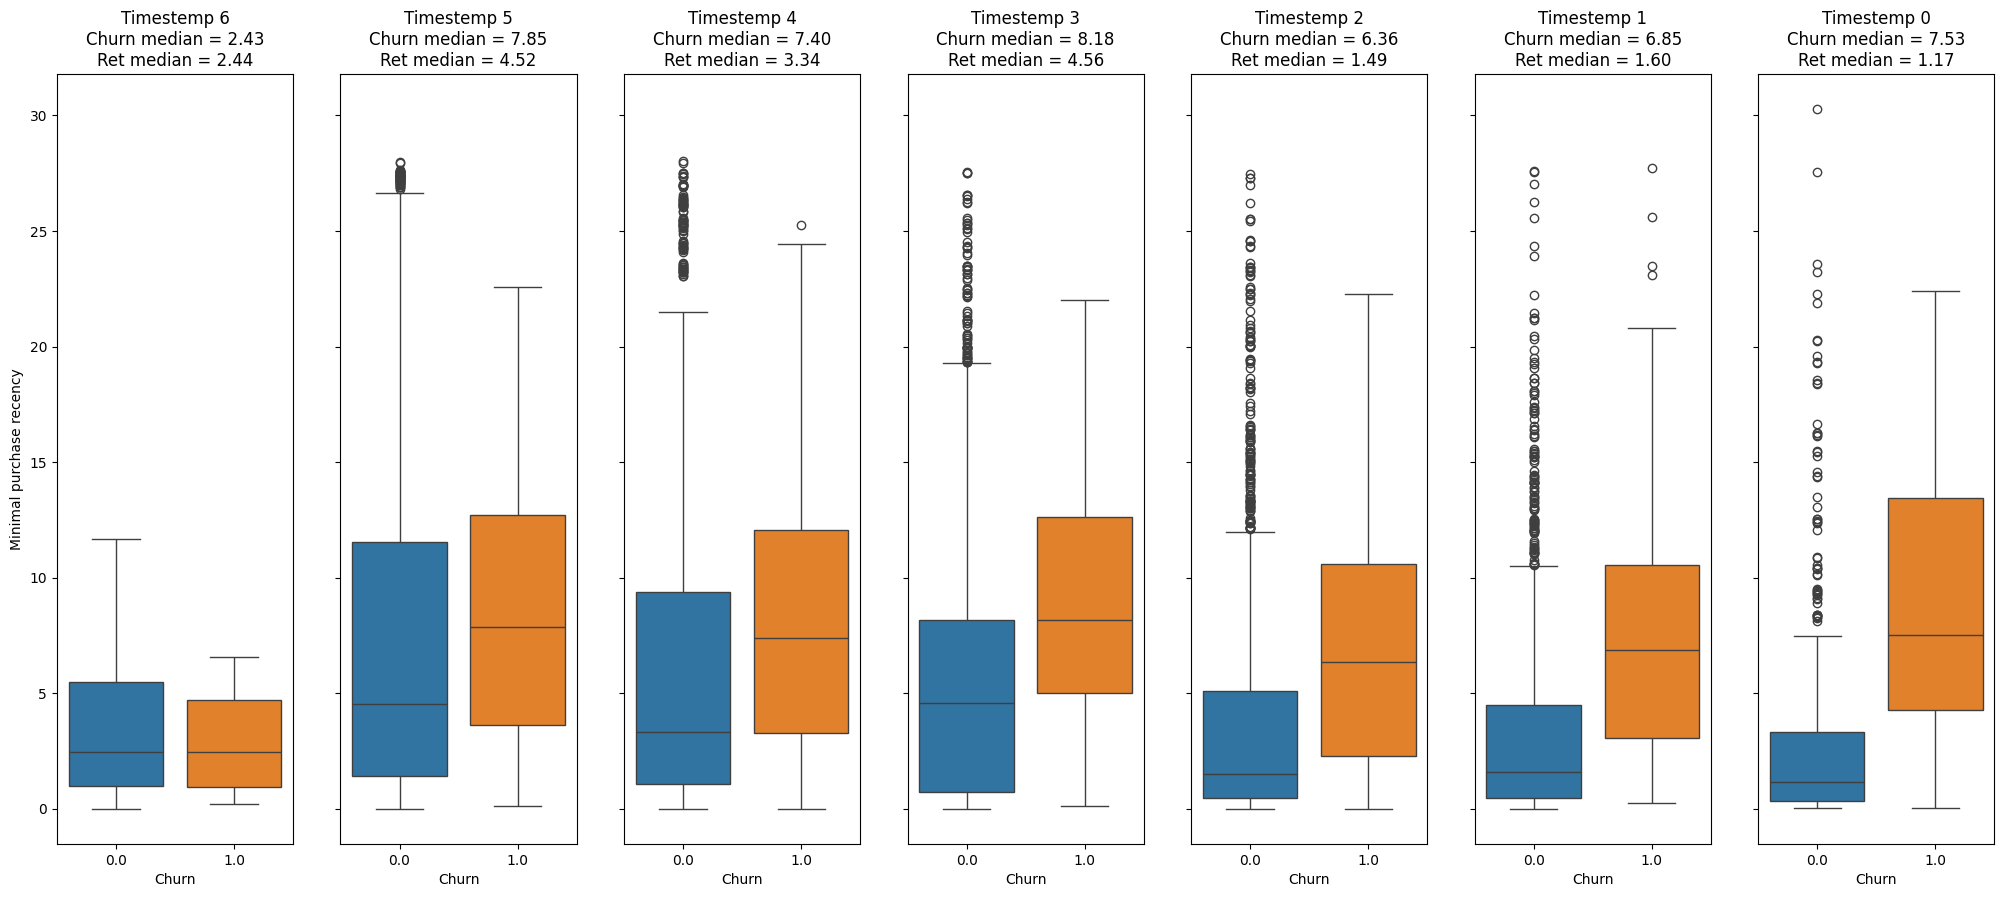

In [104]:
fig, ax = plt.subplots(1, 7, figsize=(25, 10), sharex=True, sharey=True)

for i in time_steps:
    print(i)
    prev_users = df[df.time_step > i].user_id
    tmp_df = df[(df.time_step == i) & (~df.user_id.isin(prev_users))][['target_event', 'purchase_recency_min']]
    # tmp_df = df[df.time_step == i][['target_event', 'purchase_recency_min']]
    tmp_df.columns = ['Churn', 'Minimal purchase recency']
    ax[(6 - i)].title.set_text(f'Timestemp {i}\nChurn median = {tmp_df[tmp_df.Churn == 1]['Minimal purchase recency'].median():.2f}\nRet median = {tmp_df[tmp_df.Churn == 0]['Minimal purchase recency'].median():.2f}')
    sns.boxplot(tmp_df, x='Churn', y='Minimal purchase recency', hue='Churn', ax=ax[(6 - i)], legend=False)
    # ax[4-i].set_xlabel('Churn')
    # ax[4-i].set_ylabel('Session recency')

    # plt.ylabel('Churn')



6
5
4


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


3
2
1
0


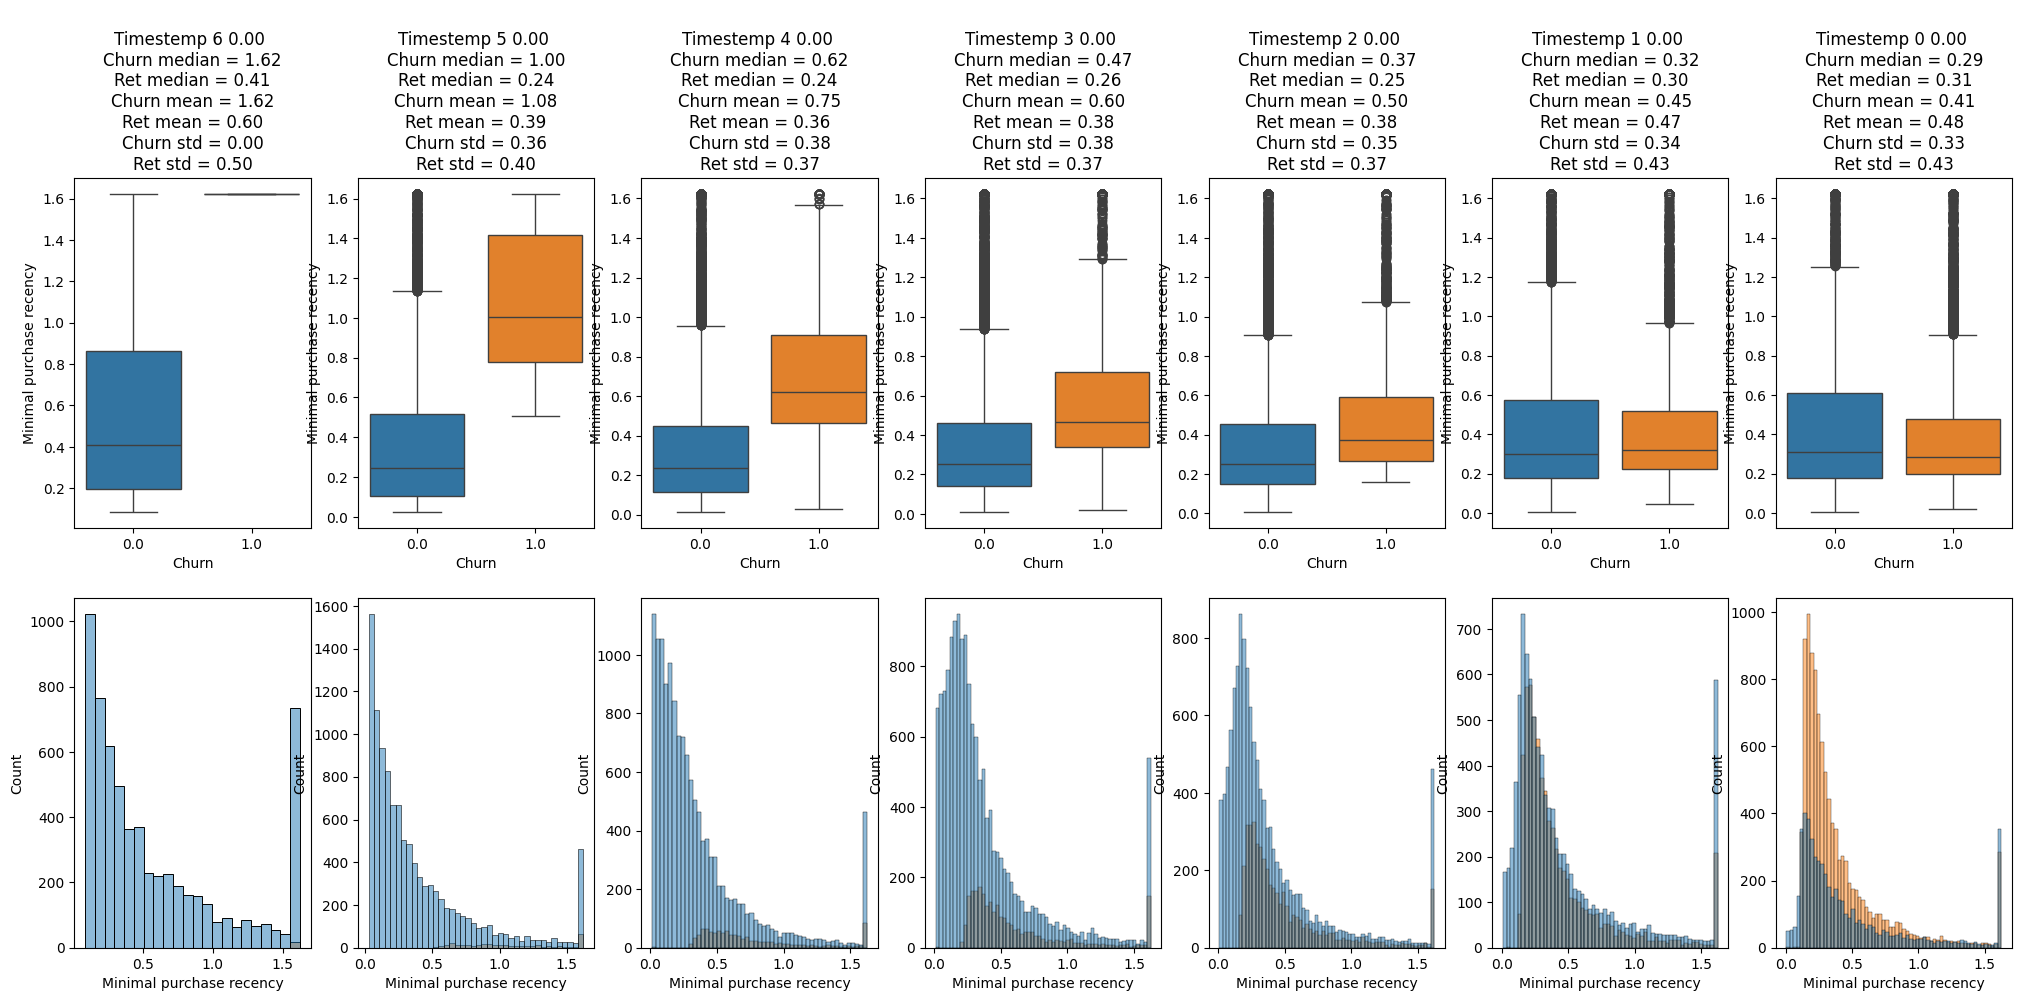

In [105]:
fig, ax = plt.subplots(2, 7, figsize=(25, 10))

for i in time_steps:
    print(i)
    # prev_users = df[df.time_step > i].user_id # transaction_count_ratio & (~df.user_id.isin(prev_users))
    tmp_df = df[(df.time_step == i) ][['target_event', 'transaction_count_ratio']]
    tmp_df = tmp_df[tmp_df.transaction_count_ratio < 5]
    # tmp_df = df[df.time_step == i][['target_event', 'purchase_recency_min']]
    tmp_df.columns = ['Churn', 'Minimal purchase recency']
    _, p = ttest_ind(tmp_df[tmp_df.Churn == 0]['Minimal purchase recency'], tmp_df[tmp_df.Churn == 1]['Minimal purchase recency'])
    ax[0][(6 - i)].title.set_text(f'''
Timestemp {i} {p:.2f} 
Churn median = {tmp_df[tmp_df.Churn == 1]['Minimal purchase recency'].median():.2f}
Ret median = {tmp_df[tmp_df.Churn == 0]['Minimal purchase recency'].median():.2f}
Churn mean = {tmp_df[tmp_df.Churn == 1]['Minimal purchase recency'].mean():.2f}
Ret mean = {tmp_df[tmp_df.Churn == 0]['Minimal purchase recency'].mean():.2f}
Churn std = {tmp_df[tmp_df.Churn == 1]['Minimal purchase recency'].std():.2f}
Ret std = {tmp_df[tmp_df.Churn == 0]['Minimal purchase recency'].std():.2f}''')
    sns.boxplot(tmp_df, x='Churn', y='Minimal purchase recency', hue='Churn', ax=ax[0][(6 - i)], legend=False)
    sns.histplot(tmp_df, x='Minimal purchase recency', ax=ax[1][(6 - i)], hue='Churn', legend=False)
    # ax[4-i].set_xlabel('Churn')
    # ax[4-i].set_ylabel('Session recency')

    # plt.ylabel('Churn')



6
5
4
3
2
1
0


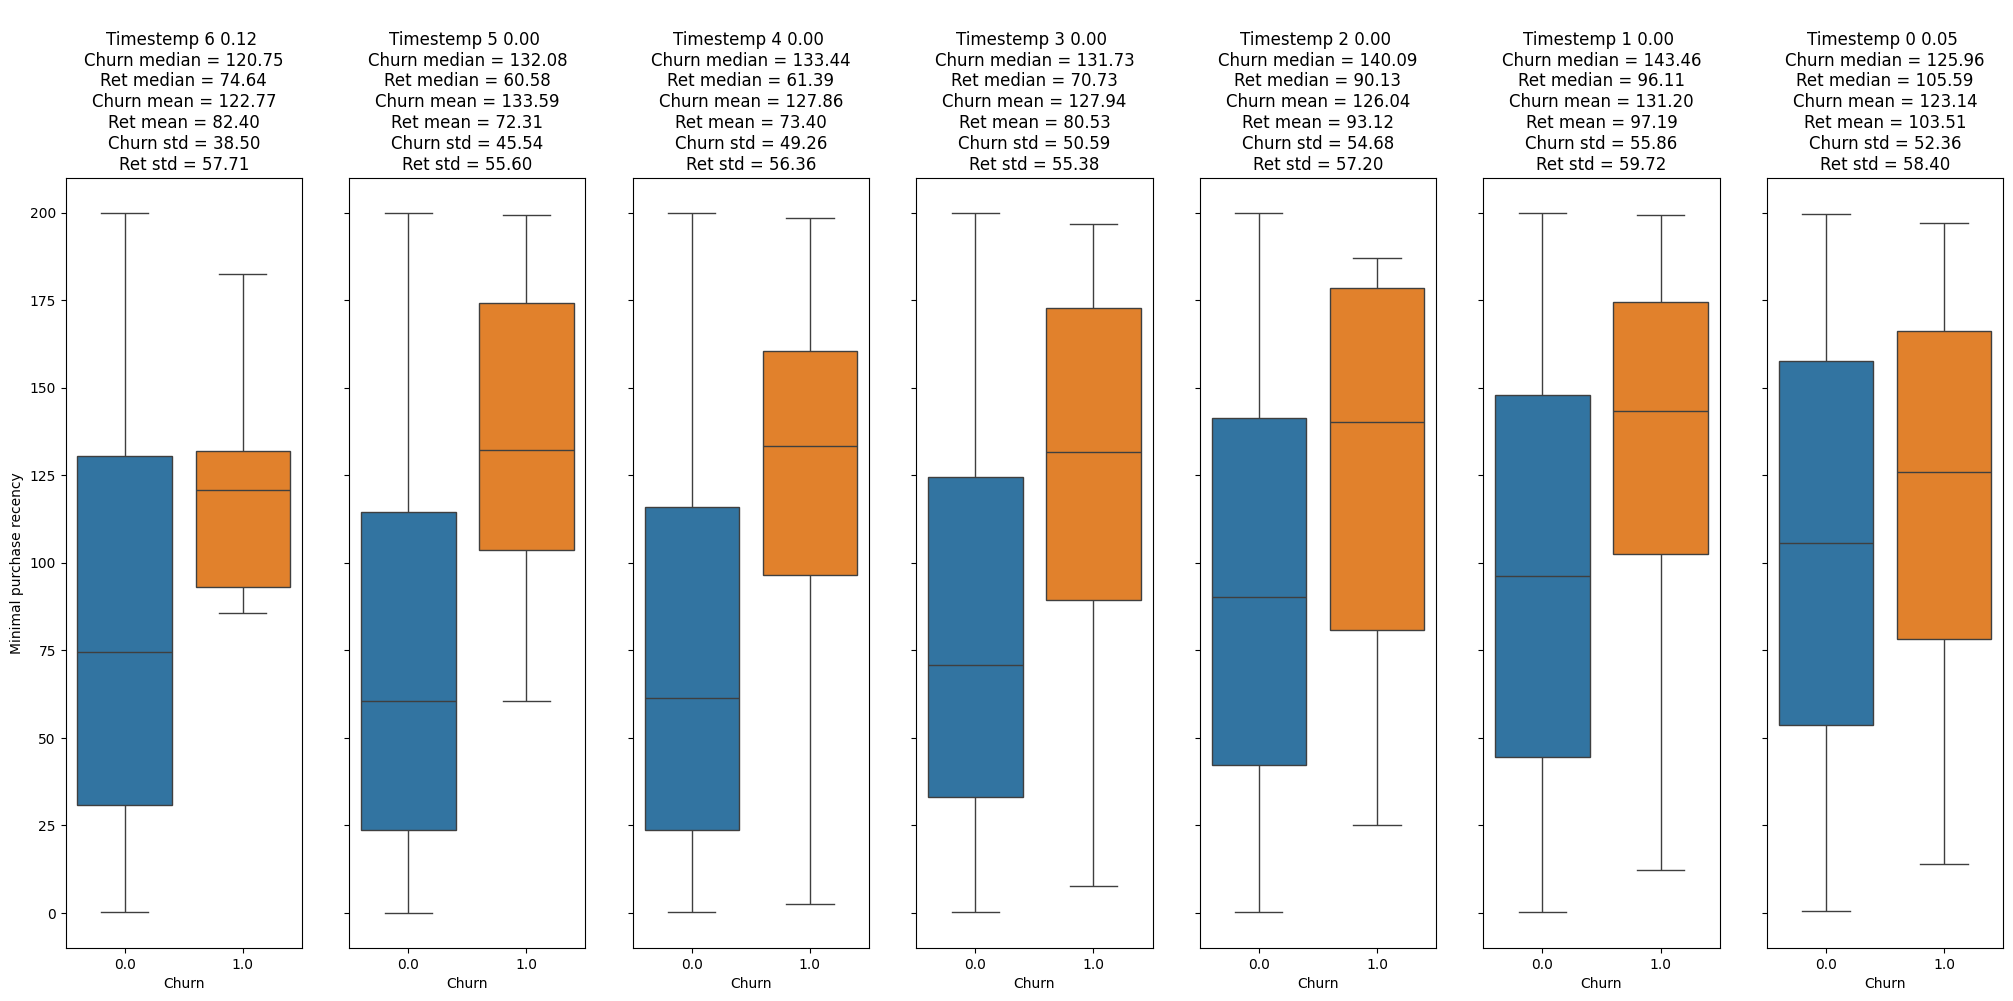

In [106]:
fig, ax = plt.subplots(1, 7, figsize=(25, 10), sharex=True, sharey=True)

for i in time_steps:
    print(i)
    prev_users = df[df.time_step > i].user_id # transaction_count_ratio 
    tmp_df = df[(df.time_step == i) & (~df.user_id.isin(prev_users))][['target_event', 'purchase_revenue_mean']]
    tmp_df = tmp_df[tmp_df.purchase_revenue_mean < 200]
    # tmp_df = df[df.time_step == i][['target_event', 'purchase_recency_min']]
    tmp_df.columns = ['Churn', 'Minimal purchase recency']
    _, p = ttest_ind(tmp_df[tmp_df.Churn == 0]['Minimal purchase recency'], tmp_df[tmp_df.Churn == 1]['Minimal purchase recency'])
    ax[(6 - i)].title.set_text(f'''
Timestemp {i} {p:.2f} 
Churn median = {tmp_df[tmp_df.Churn == 1]['Minimal purchase recency'].median():.2f}
Ret median = {tmp_df[tmp_df.Churn == 0]['Minimal purchase recency'].median():.2f}
Churn mean = {tmp_df[tmp_df.Churn == 1]['Minimal purchase recency'].mean():.2f}
Ret mean = {tmp_df[tmp_df.Churn == 0]['Minimal purchase recency'].mean():.2f}
Churn std = {tmp_df[tmp_df.Churn == 1]['Minimal purchase recency'].std():.2f}
Ret std = {tmp_df[tmp_df.Churn == 0]['Minimal purchase recency'].std():.2f}''')
    sns.boxplot(tmp_df, x='Churn', y='Minimal purchase recency', hue='Churn', ax=ax[(6 - i)], legend=False)
    # ax[4-i].set_xlabel('Churn')
    # ax[4-i].set_ylabel('Session recency')

    # plt.ylabel('Churn')


6
5
4
3
2
1
0


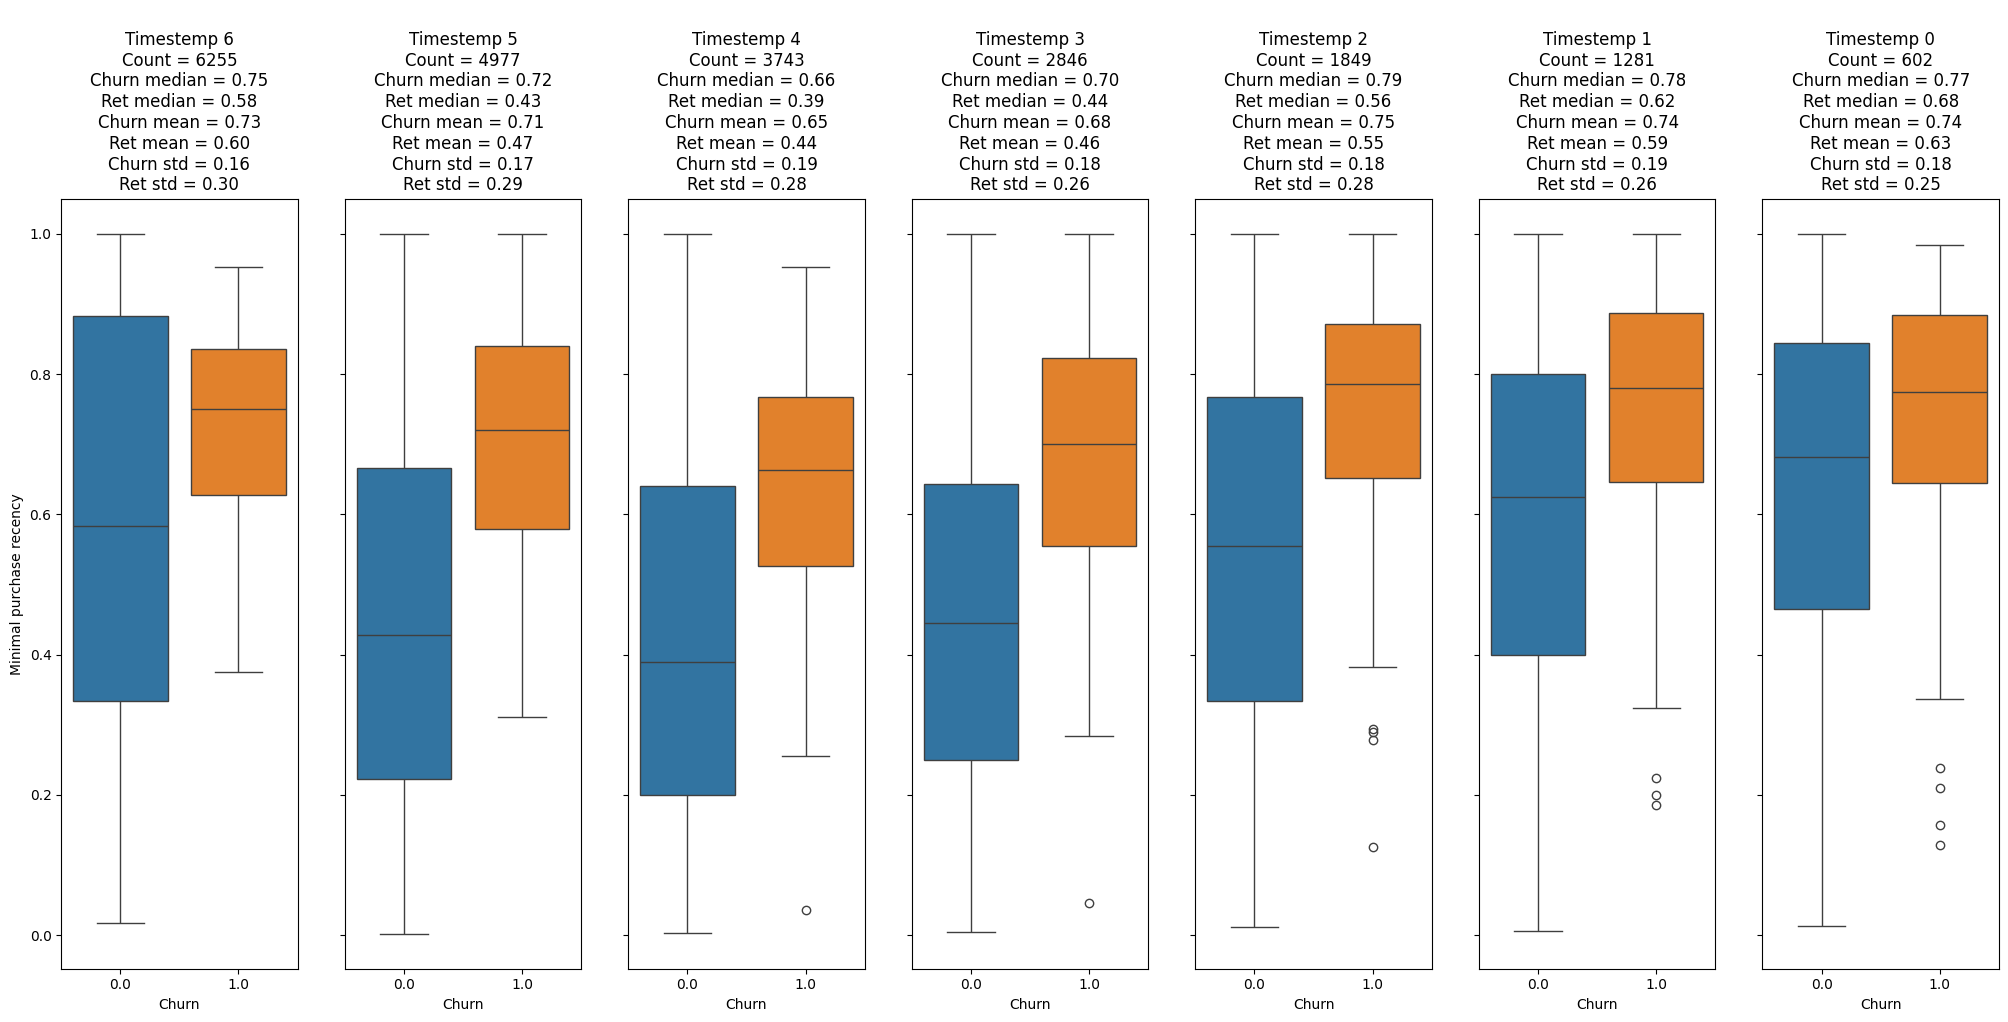

In [107]:
fig, ax = plt.subplots(1, 7, figsize=(25, 10), sharex=True, sharey=True)

for i in time_steps:
    print(i)
    prev_users = df[df.time_step > i].user_id # transaction_count_ratio 
    tmp_df = df[(df.time_step == i) & (~df.user_id.isin(prev_users))][['target_event', 'haspurchase_mean']]
    # tmp_df = tmp_df[tmp_df.haspurchase_mean < 200]
    # tmp_df = df[df.time_step == i][['target_event', 'purchase_recency_min']]
    tmp_df.columns = ['Churn', 'Minimal purchase recency']
    ax[(6 - i)].title.set_text(f'''
Timestemp {i}
Count = {len(tmp_df)}
Churn median = {tmp_df[tmp_df.Churn == 1]['Minimal purchase recency'].median():.2f}
Ret median = {tmp_df[tmp_df.Churn == 0]['Minimal purchase recency'].median():.2f}
Churn mean = {tmp_df[tmp_df.Churn == 1]['Minimal purchase recency'].mean():.2f}
Ret mean = {tmp_df[tmp_df.Churn == 0]['Minimal purchase recency'].mean():.2f}
Churn std = {tmp_df[tmp_df.Churn == 1]['Minimal purchase recency'].std():.2f}
Ret std = {tmp_df[tmp_df.Churn == 0]['Minimal purchase recency'].std():.2f}''')
    sns.boxplot(tmp_df, x='Churn', y='Minimal purchase recency', hue='Churn', ax=ax[(6 - i)], legend=False)
    # ax[4-i].set_xlabel('Churn')
    # ax[4-i].set_ylabel('Session recency')

    # plt.ylabel('Churn')

6
5
4
3
2
1
0


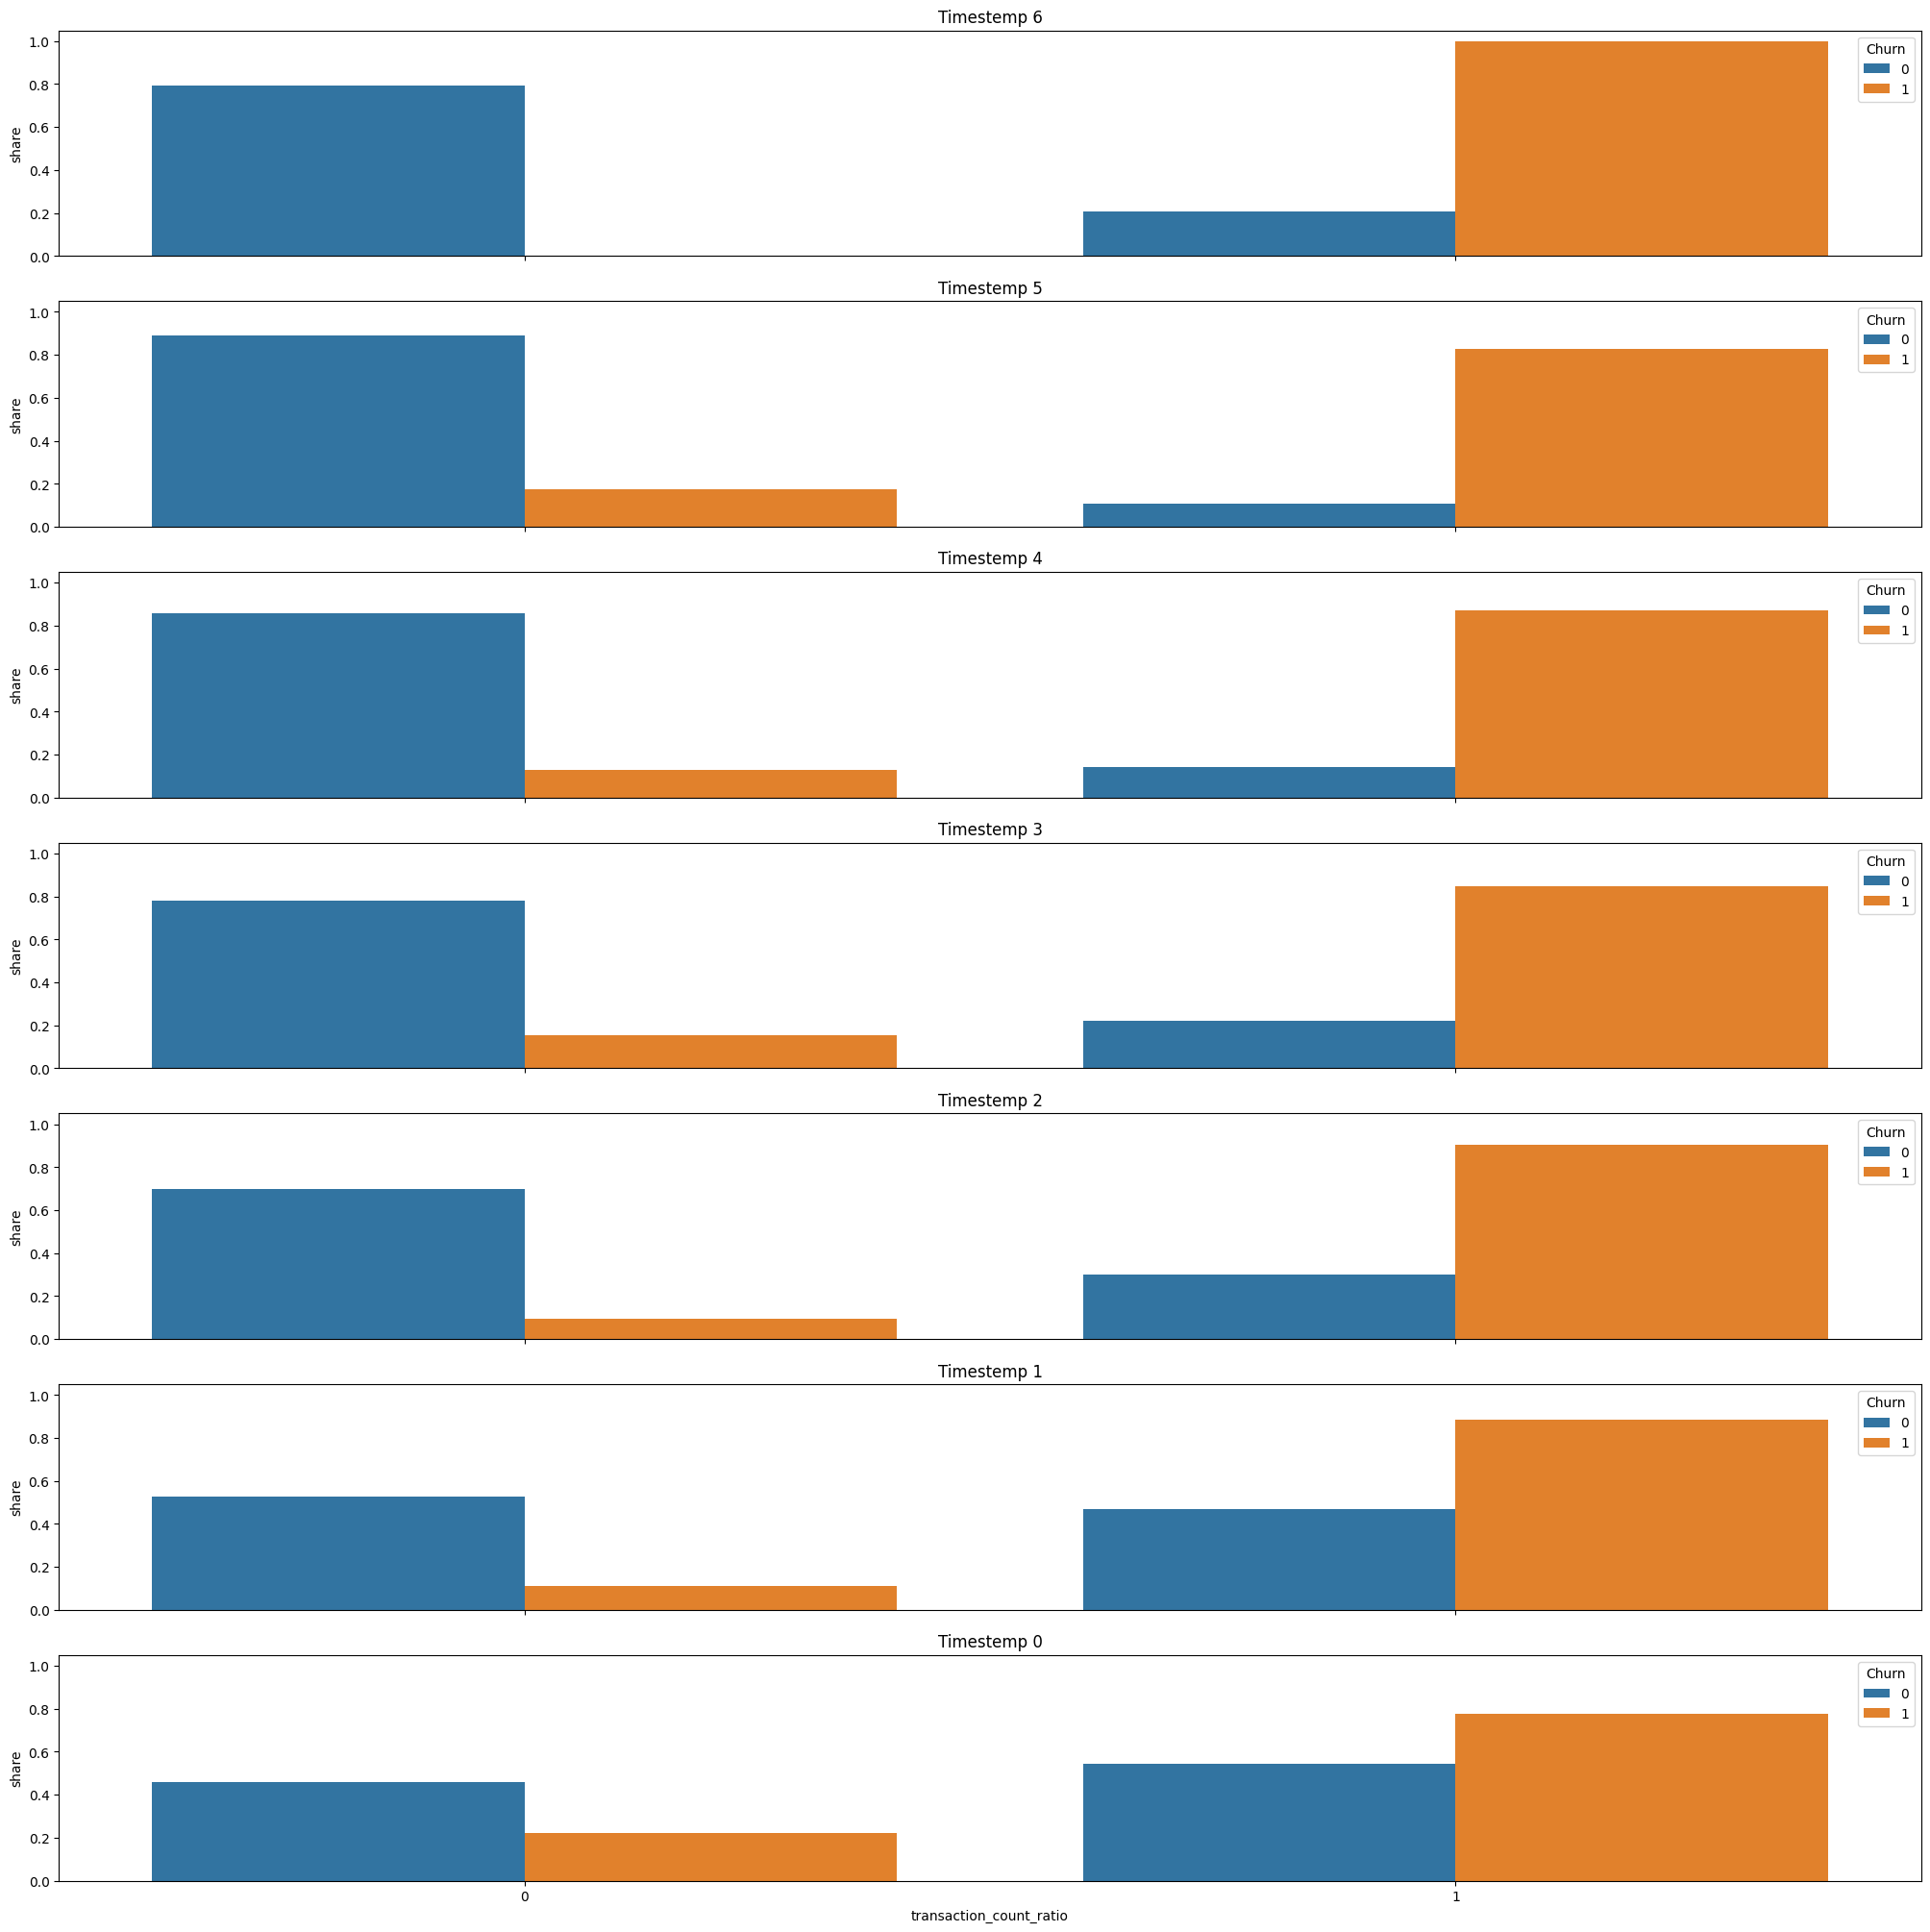

In [108]:
fig, ax = plt.subplots(7, 1, figsize=(25, 25), sharex=True, sharey=True)

for i in time_steps:
    print(i)
    prev_users = df[df.time_step > i].user_id  
    tmp_df = df[(df.time_step == i)& (~df.user_id.isin(prev_users))][['target_event', 'transaction_count_ratio']]
    tmp_df.transaction_count_ratio = tmp_df.transaction_count_ratio.apply(int)
    tmp_df.transaction_count_ratio = tmp_df.transaction_count_ratio.apply(int)
    churn_df = tmp_df[tmp_df.target_event == 1]
    ret_df = tmp_df[tmp_df.target_event == 0]
    grouped_churn_df = churn_df.groupby('transaction_count_ratio', as_index=False).count()
    grouped_churn_df['share'] = grouped_churn_df.target_event / grouped_churn_df.target_event.sum()
    grouped_churn_df = grouped_churn_df.drop('target_event', axis=1)
    grouped_churn_df['Churn'] = 1
    grouped_ret_df = ret_df.groupby('transaction_count_ratio', as_index=False).count()
    grouped_ret_df['share'] = grouped_ret_df.target_event / grouped_ret_df.target_event.sum()
    grouped_ret_df = grouped_ret_df.drop('target_event', axis=1)
    grouped_ret_df['Churn'] = 0
    tmp_df = pd.concat([grouped_ret_df, grouped_churn_df])
    tmp_df = tmp_df[tmp_df.transaction_count_ratio < 10]
    # tmp_df.columns = ['Churn', 'Ratio transactions per day']
    # \nChurn median = {tmp_df[tmp_df.Churn == 1]['Ratio transactions per day'].median():.2f}\nRet median = {tmp_df[tmp_df.Churn == 0]['Ratio transactions per day'].median():.2f}
    ax[(6 - i)].title.set_text(f'Timestemp {i}')
    # display(tmp_df)
    sns.barplot(tmp_df, x='transaction_count_ratio', y='share', hue='Churn', ax=ax[(6 - i)])

    # ax[4-i].set_xlabel('Churn')
    # ax[4-i].set_ylabel('Session recency')

    # plt.ylabel('Churn')


In [193]:
df.purchase_revenue_sum.describe()

count    112610.000000
mean      11407.348662
std       20050.513379
min           1.130000
25%        2271.122500
50%        6083.225000
75%       13402.215000
max      750164.810000
Name: purchase_revenue_sum, dtype: float64

6
5
4
3
2
1
0


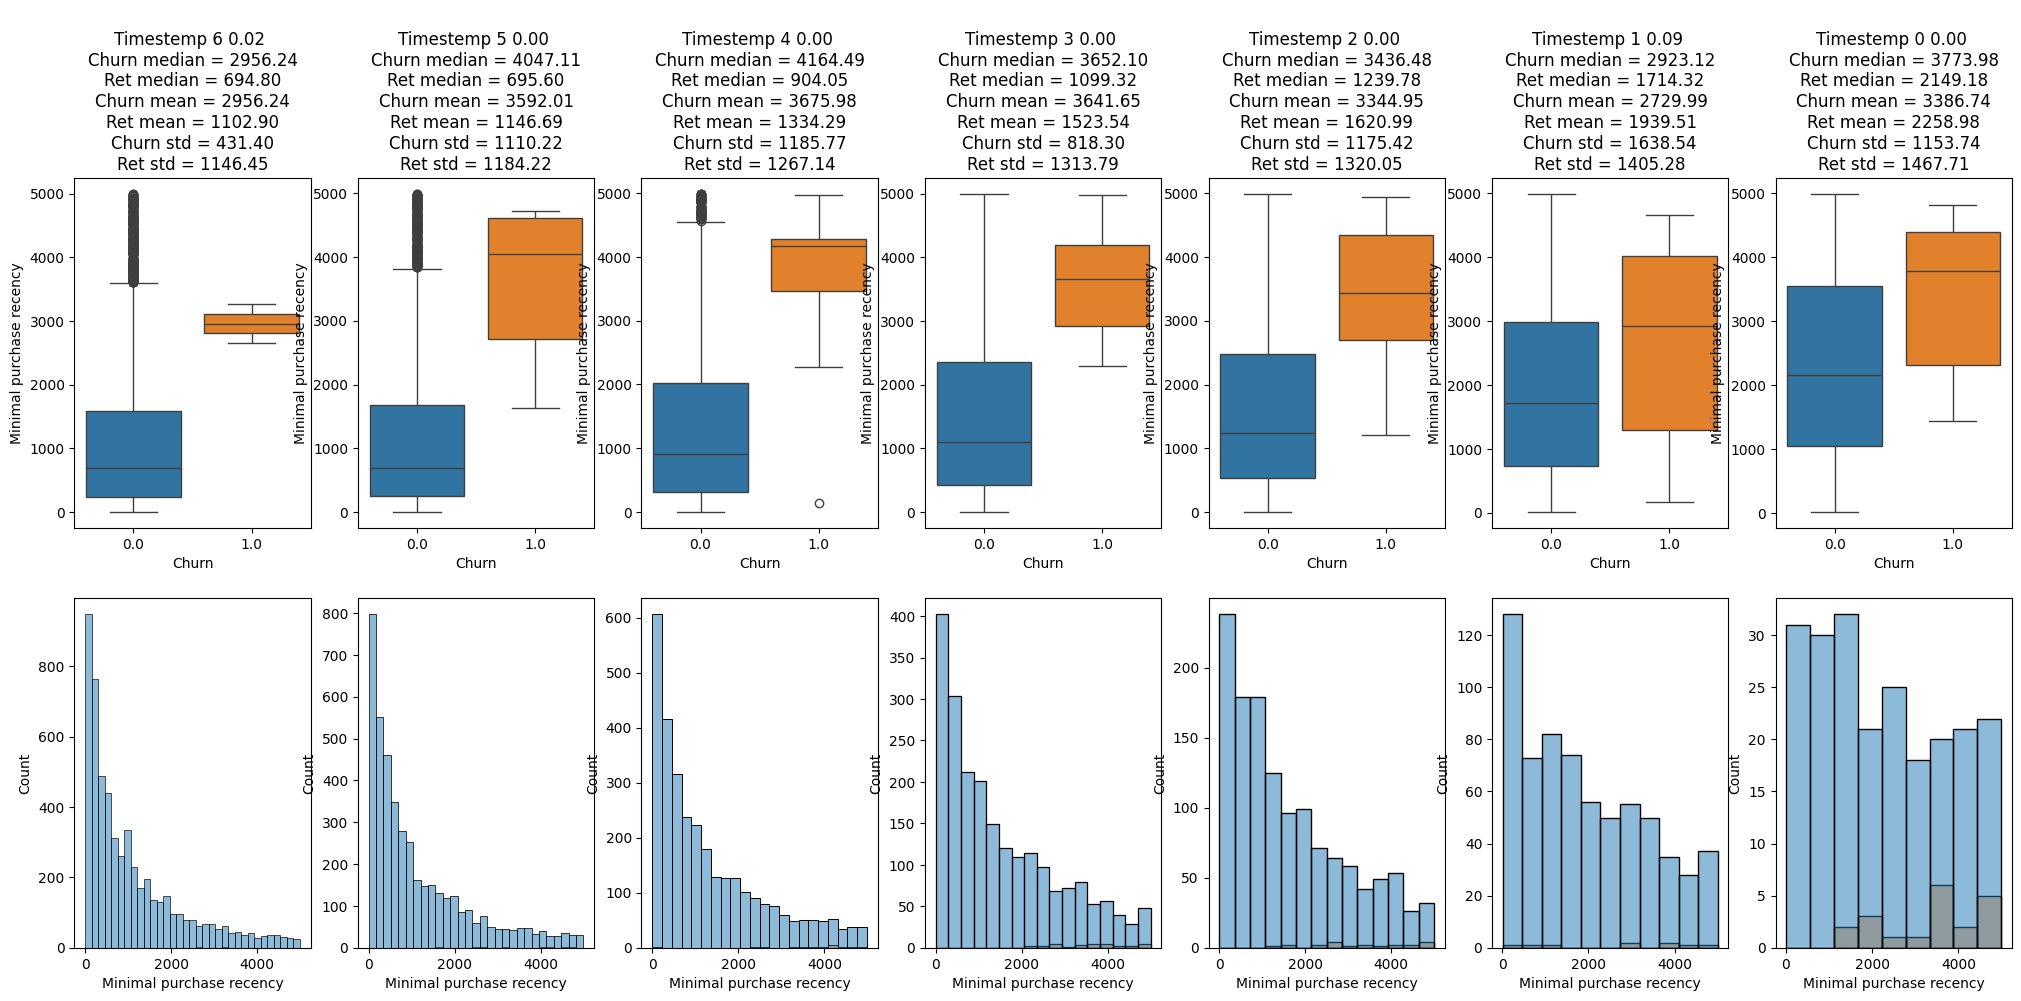

In [109]:
fig, ax = plt.subplots(2, 7, figsize=(25, 10))

for i in time_steps:
    print(i)
    prev_users = df[df.time_step > i].user_id # transaction_count_ratio 
    tmp_df = df[(df.time_step == i) & (~df.user_id.isin(prev_users))][['target_event', 'purchase_revenue_sum']]
    tmp_df = tmp_df[tmp_df.purchase_revenue_sum < 5000]
    # tmp_df = df[df.time_step == i][['target_event', 'purchase_recency_min']]
    tmp_df.columns = ['Churn', 'Minimal purchase recency']
    _, p = ttest_ind(tmp_df[tmp_df.Churn == 0]['Minimal purchase recency'], tmp_df[tmp_df.Churn == 1]['Minimal purchase recency'])
    ax[0][(6 - i)].title.set_text(f'''
Timestemp {i} {p:.2f} 
Churn median = {tmp_df[tmp_df.Churn == 1]['Minimal purchase recency'].median():.2f}
Ret median = {tmp_df[tmp_df.Churn == 0]['Minimal purchase recency'].median():.2f}
Churn mean = {tmp_df[tmp_df.Churn == 1]['Minimal purchase recency'].mean():.2f}
Ret mean = {tmp_df[tmp_df.Churn == 0]['Minimal purchase recency'].mean():.2f}
Churn std = {tmp_df[tmp_df.Churn == 1]['Minimal purchase recency'].std():.2f}
Ret std = {tmp_df[tmp_df.Churn == 0]['Minimal purchase recency'].std():.2f}''')
    sns.boxplot(tmp_df, x='Churn', y='Minimal purchase recency', hue='Churn', ax=ax[0][(6 - i)], legend=False)
    sns.histplot(tmp_df, x='Minimal purchase recency', ax=ax[1][(6 - i)], hue='Churn', legend=False)
    # ax[4-i].set_xlabel('Churn')
    # ax[4-i].set_ylabel('Session recency')

    # plt.ylabel('Churn')


In [114]:
tmp_df

,Churn,Ratio transactions per day
58,0,2.525204
99,1,0.640764
115,0,1.079036
127,0,0.540783
134,1,2.973093
...,...,...
109601,0,0.456804
109612,0,0.120644
109731,1,1.657665
109732,0,2.874593


<Axes: xlabel='target_event', ylabel='session_recency_mean'>

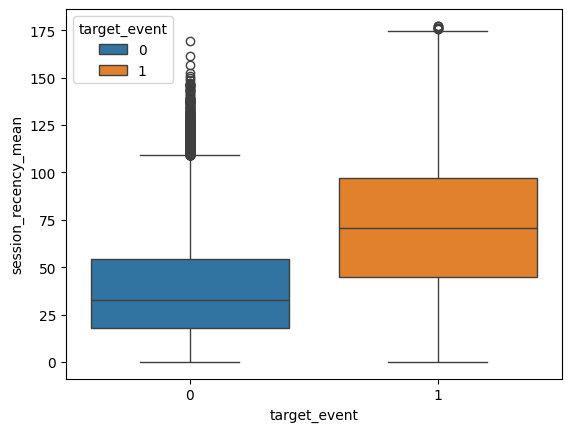

In [36]:
sns.boxplot(df, x='target_event', y='session_recency_mean', hue='target_event')


In [57]:
def get_train_test_split(df, features=[], target='target_event', train_test_ts_separator = 2):
    test = df[df.time_step == train_test_ts_separator]
    train = df[df.time_step > train_test_ts_separator]
    if len(features) == 0:
        columns = list(filter((lambda x: ('start_' not in x) \
                       and x not in untouchable_cols), list(df.columns)))
        return train[columns], train[target], test[columns], test[target]    
    return train[features], test[features], train[target], test[target]

In [58]:
get_train_test_split(df)

(        length_mean  haspurchase_mean  click_count_mean  view_count_mean  \
 2259      14.707005          0.724638          9.130435         4.347826   
 2260       4.781667          0.900000          4.100000         2.300000   
 2261       4.894715          0.353659          6.304878         5.280488   
 2262       4.920139          0.145833          5.229166         4.833334   
 2263       1.837500          0.250000          2.250000         1.750000   
 ...             ...               ...               ...              ...   
 112605     4.961111          0.666667          9.000000         8.000000   
 112606     9.433333          1.000000         13.000000        12.000000   
 112607     4.493333          0.200000          4.600000         4.400000   
 112608     4.537121          0.181818          7.181818         6.954546   
 112609    18.839583          0.375000         11.000000         9.375000   
 
         cart_count_mean  purchase_count_mean  time_to_click_mean  \
 2259

# Отбор признаков

In [111]:
df.drop(untouchable_cols, axis=1).shape

(98122, 270)

In [118]:
columns

['length_mean',
 'haspurchase_mean',
 'click_count_mean',
 'view_count_mean',
 'cart_count_mean',
 'purchase_count_mean',
 'time_to_click_mean',
 'time_to_view_mean',
 'time_to_cart_mean',
 'time_to_purchase_mean',
 'view_revenue_mean',
 'cart_revenue_mean',
 'purchase_revenue_mean',
 'time_to_click_revenue_mean',
 'time_to_view_revenue_mean',
 'time_to_cart_revenue_mean',
 'time_to_purchase_revenue_mean',
 'session_number_mean',
 'inter_session_time_mean',
 'session_recency_mean',
 'purchase_number_mean',
 'inter_purchase_time_mean',
 'purchase_recency_mean',
 'length_sum',
 'haspurchase_sum',
 'click_count_sum',
 'view_count_sum',
 'cart_count_sum',
 'purchase_count_sum',
 'time_to_click_sum',
 'time_to_view_sum',
 'time_to_cart_sum',
 'time_to_purchase_sum',
 'view_revenue_sum',
 'cart_revenue_sum',
 'purchase_revenue_sum',
 'time_to_click_revenue_sum',
 'time_to_view_revenue_sum',
 'time_to_cart_revenue_sum',
 'time_to_purchase_revenue_sum',
 'session_number_sum',
 'inter_session_t

In [ ]:
correlate_cols = []
c = 0
for col in columns:
    if col in untouchable_cols:
        continue
    if ('start_' in col) or ('target' in col) or ('stddev' in col) or ('cv' in col) or ('max' in col) or ('min' in col):
        continue
    correlate_cols.append(col)
    c += 1
c

176

In [149]:
corr_matrix.columns

Index(['click_count_mean', 'view_count_mean', 'time_to_click_mean',
       'time_to_view_mean', 'time_to_cart_mean', 'time_to_click_revenue_mean',
       'time_to_view_revenue_mean', 'time_to_cart_revenue_mean',
       'session_recency_mean', 'purchase_number_mean', 'purchase_recency_mean',
       'length_sum', 'haspurchase_sum', 'click_count_sum', 'view_count_sum',
       'purchase_count_sum', 'time_to_click_sum', 'time_to_view_sum',
       'time_to_cart_sum', 'time_to_click_revenue_sum',
       'time_to_view_revenue_sum', 'time_to_cart_revenue_sum',
       'time_to_purchase_revenue_sum', 'purchase_number_sum', 'length_max',
       'click_count_max', 'view_count_max', 'time_to_click_max',
       'time_to_view_max', 'time_to_cart_max', 'time_to_click_revenue_max',
       'time_to_view_revenue_max', 'time_to_cart_revenue_max',
       'time_to_purchase_revenue_max', 'session_recency_max',
       'purchase_number_max', 'purchase_recency_max'],
      dtype='object')

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


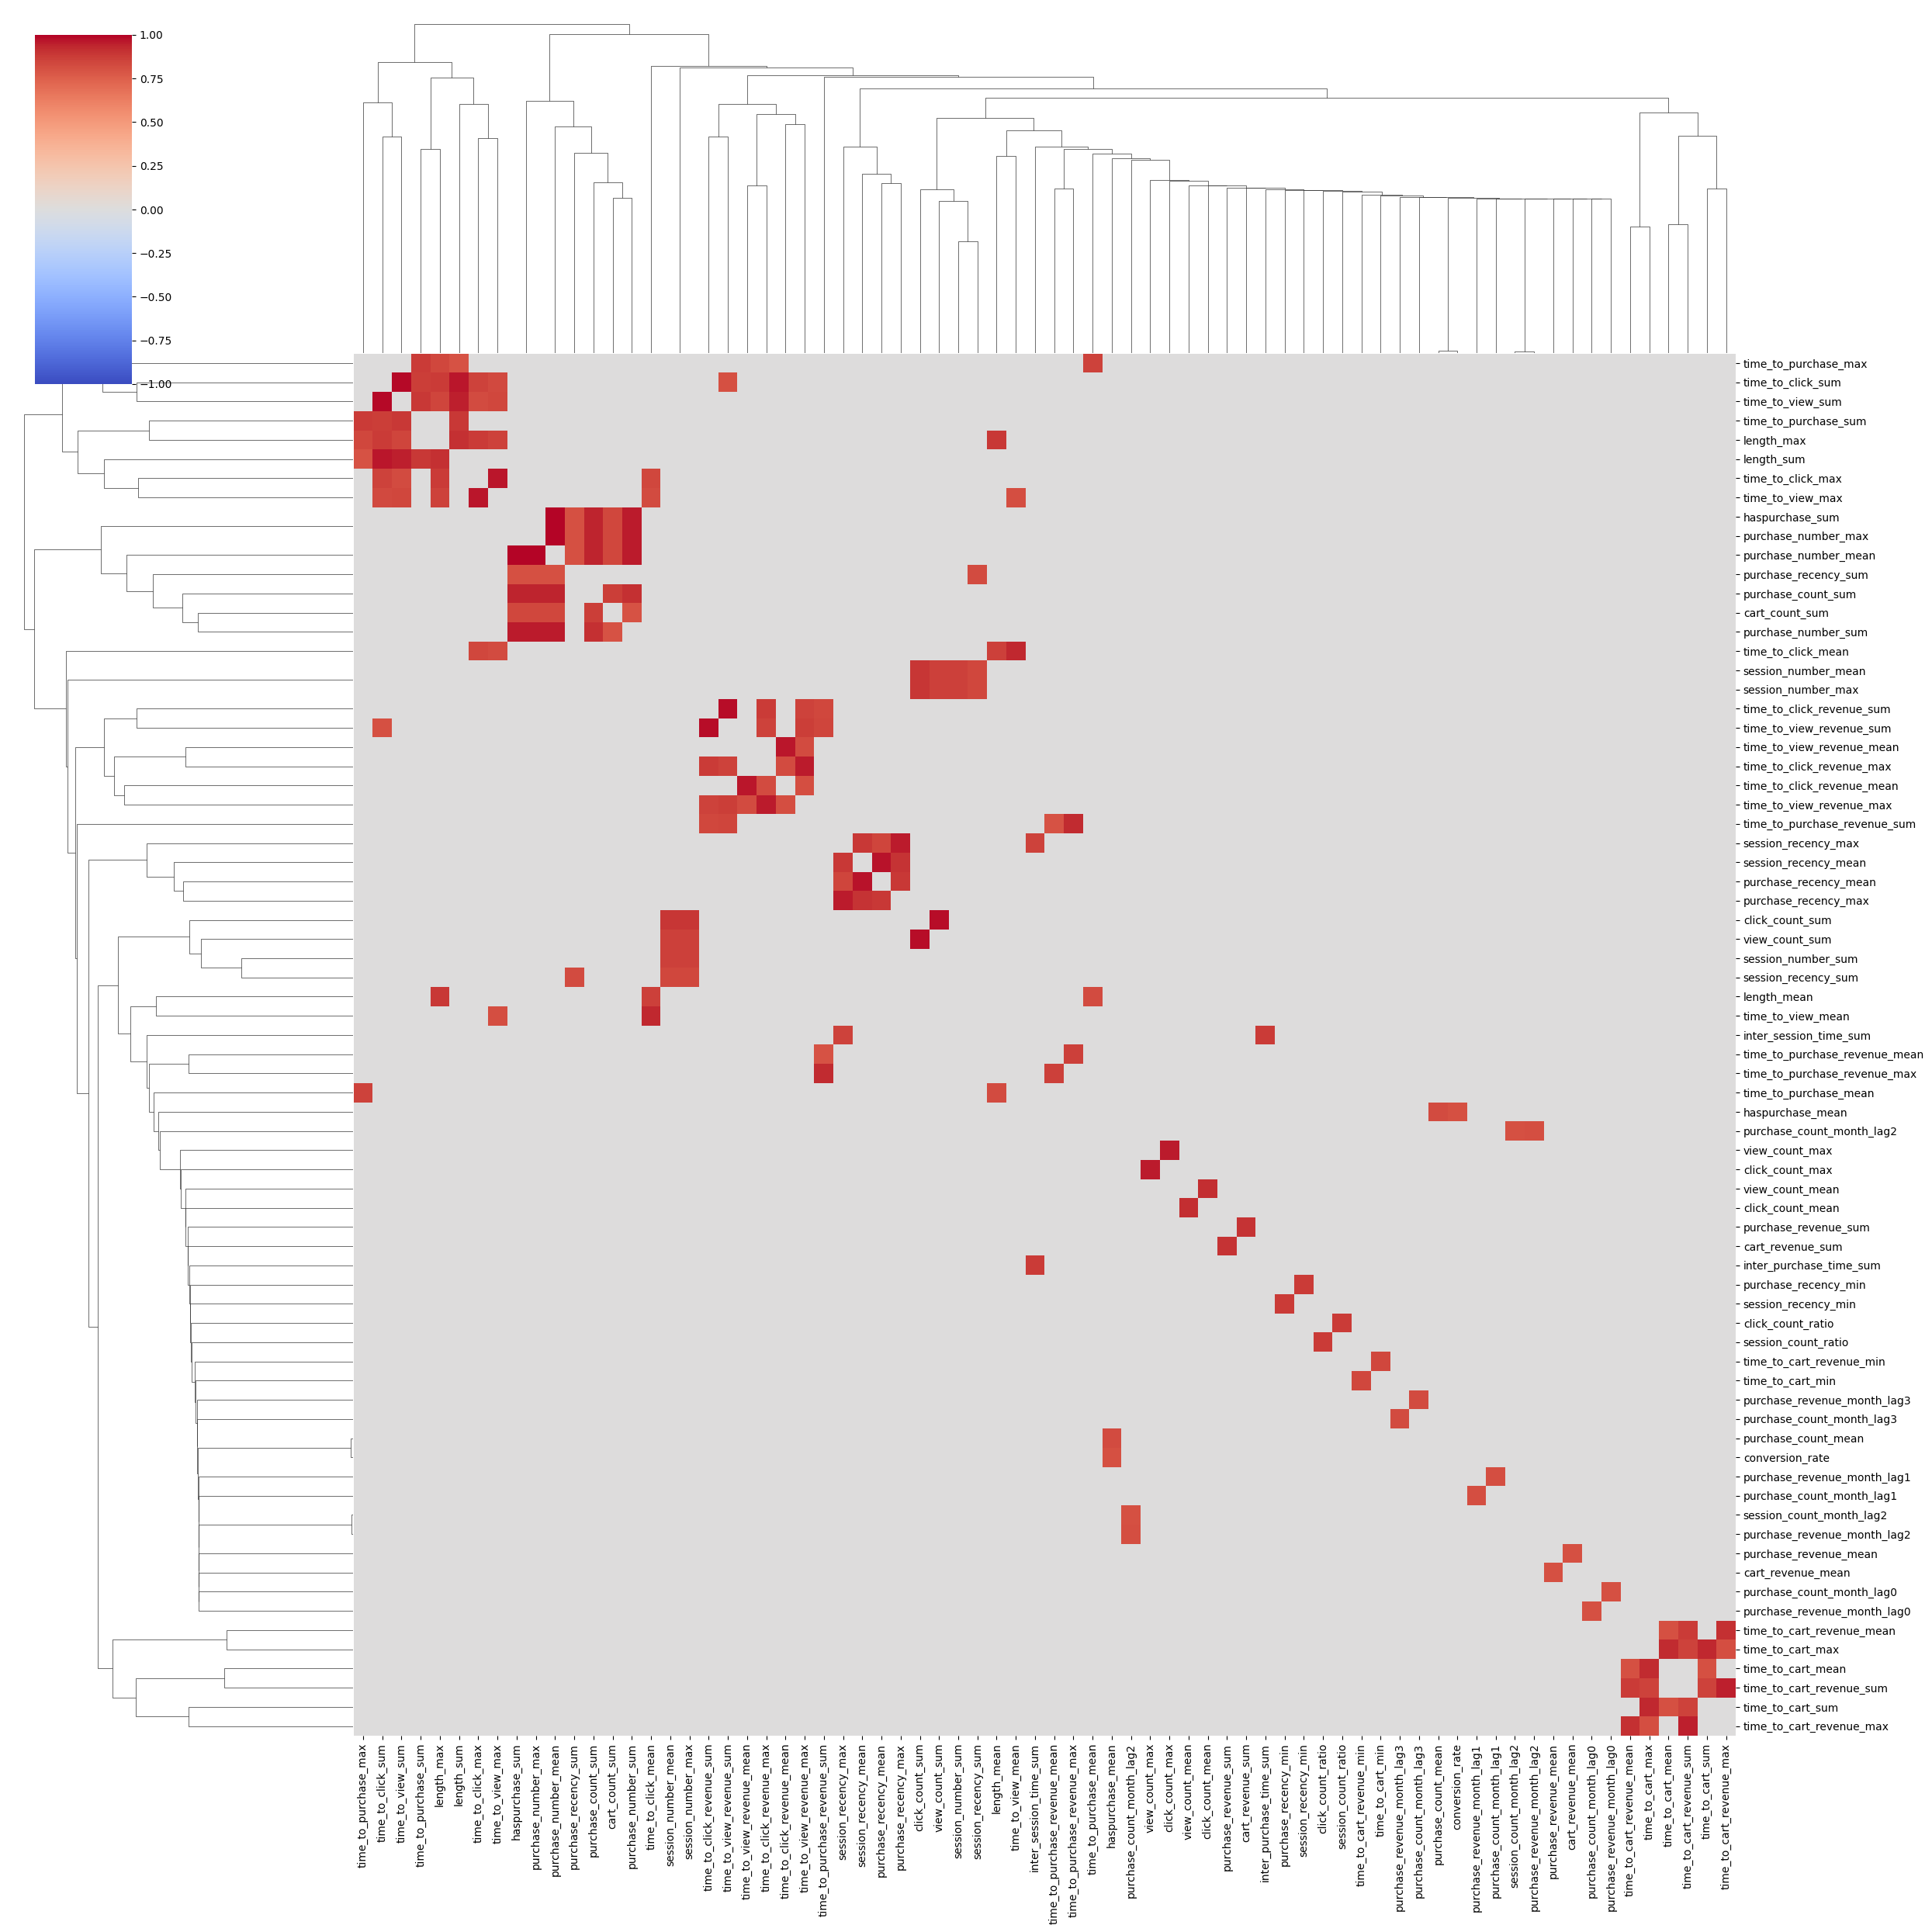

In [204]:
# plt.figure(figsize=(50, 45))
corr_matrix = df[correlate_cols].corr()
corr_matrix = corr_matrix[(corr_matrix>=0.8) | (corr_matrix<=-0.8)].replace(1.0, np.nan).dropna(how='all').dropna(axis=1, how='all').fillna(0)
sns.clustermap(corr_matrix, vmin=-1, vmax=+1, cmap="coolwarm", figsize=(25, 25)) 

plt.show()

In [ ]:
leave_by_cluster = [
    'length_max',
    'purchase_count_sum',
    'time_to_click_revenue_mean',
    ''
]

In [171]:
corr_pairs = []
for col in corr_matrix.columns:
    for row in corr_matrix.index:
        if (corr_matrix[row][col] != 0):
            corr_pairs.append((*sorted([col, row]), float(corr_matrix[row][col])))
corr_pairs = sorted(list(set(corr_pairs)), key=lambda x: x[2], reverse=True)

In [172]:
len(corr_pairs)

102

In [ ]:
items_to_remove = []
items_to_leave = []

In [180]:

for pair in list(set(corr_pairs))[82:]:
    print(pair)
    index_to_leave = int(input()) - 1
    items_to_leave.append(pair[index_to_leave])
    items_to_remove.append(pair[(index_to_leave + 1) % 2])


('purchase_recency_sum', 'session_recency_sum', 0.8280978065068874)
('time_to_purchase_revenue_sum', 'time_to_view_revenue_sum', 0.8503369405811849)
('length_sum', 'time_to_purchase_sum', 0.8885854538407595)
('time_to_cart_max', 'time_to_cart_revenue_sum', 0.8535290179119119)
('time_to_click_revenue_mean', 'time_to_view_revenue_max', 0.8173019543946954)
('cart_count_sum', 'purchase_number_max', 0.8392719535523562)
('time_to_click_mean', 'time_to_view_max', 0.8212950431261045)
('click_count_mean', 'view_count_mean', 0.9179185044835889)
('purchase_recency_max', 'purchase_recency_mean', 0.889464946287082)
('length_max', 'length_mean', 0.8845155653107365)
('haspurchase_sum', 'purchase_number_sum', 0.960049273025525)
('purchase_count_month_lag0', 'purchase_revenue_month_lag0', 0.8093892386812629)
('session_number_max', 'session_recency_sum', 0.8414603218393654)
('length_max', 'time_to_click_max', 0.8809945708020055)
('time_to_cart_revenue_sum', 'time_to_cart_sum', 0.8583475715578675)
('time

In [ ]:
items_to_remove = ['time_to_cart_revenue_min',
 'time_to_click_revenue_max',
 'purchase_number_mean',
 'click_count_ratio',
 'time_to_cart_revenue_sum',
 'inter_purchase_time_sum',
 'time_to_click_mean',
 'time_to_view_revenue_max',
 'click_count_sum',
 'purchase_revenue_month_lag2',
 'click_count_max',
 'view_count_sum',
 'time_to_view_revenue_sum',
 'time_to_cart_revenue_mean',
 'cart_count_sum',
 'session_count_month_lag2',
 'time_to_purchase_max',
 'cart_revenue_mean',
 'time_to_click_sum',
 'session_recency_mean',
 'time_to_click_revenue_mean',
 'purchase_revenue_month_lag1',
 'purchase_recency_mean',
 'session_recency_min',
 'session_number_max',
 'click_count_mean',
 'time_to_view_max',
 'time_to_purchase_revenue_mean',
 'cart_revenue_sum',
 'haspurchase_sum',
 'session_recency_sum',
 'purchase_revenue_month_lag0',
 'session_number_mean',
 'time_to_view_sum',
 'purchase_number_max',
 'purchase_number_sum',
 'time_to_click_max',
 'length_mean',
 'time_to_click_revenue_sum',
 'haspurchase_mean',
 'length_sum',
 'inter_session_time_sum',
 'time_to_cart_max',
 'length_max',
 'time_to_cart_revenue_max',
 'time_to_purchase_revenue_max',
 'purchase_revenue_month_lag3',
 'time_to_cart_mean',
 'session_recency_max']

In [189]:
set(items_to_leave).intersection(set(items_to_remove))

{'cart_count_sum',
 'click_count_sum',
 'haspurchase_sum',
 'inter_session_time_sum',
 'length_max',
 'length_sum',
 'purchase_number_max',
 'purchase_number_sum',
 'purchase_recency_mean',
 'session_number_max',
 'session_recency_max',
 'session_recency_sum',
 'time_to_cart_max',
 'time_to_cart_mean',
 'time_to_cart_revenue_mean',
 'time_to_cart_revenue_sum',
 'time_to_click_max',
 'time_to_click_mean',
 'time_to_click_revenue_mean',
 'time_to_click_revenue_sum',
 'time_to_click_sum',
 'time_to_purchase_max',
 'time_to_purchase_revenue_mean',
 'time_to_view_max',
 'time_to_view_revenue_max',
 'time_to_view_revenue_sum',
 'time_to_view_sum',
 'view_count_sum'}

In [186]:
items_to_leave = ['purchase_count_month_lag1',
 'purchase_count_mean',
 'purchase_revenue_mean',
 'time_to_view_revenue_mean',
 'time_to_purchase_mean',
 'time_to_cart_revenue_sum',
 'time_to_click_mean',
 'time_to_view_revenue_max',
 'click_count_sum',
 'conversion_rate',
 'time_to_cart_sum',
 'time_to_cart_revenue_mean',
 'view_count_sum',
 'time_to_view_revenue_sum',
 'purchase_recency_sum',
 'cart_count_sum',
 'view_count_mean',
 'time_to_purchase_max',
 'time_to_click_sum',
 'time_to_click_revenue_mean',
 'purchase_recency_mean',
 'purchase_recency_min',
 'time_to_purchase_sum',
 'purchase_count_month_lag3',
 'session_number_max',
 'purchase_count_sum',
 'time_to_view_max',
 'time_to_purchase_revenue_mean',
 'haspurchase_sum',
 'session_number_sum',
 'session_recency_sum',
 'purchase_count_month_lag2',
 'view_count_max',
 'time_to_cart_min',
 'time_to_view_sum',
 'purchase_count_month_lag0',
 'purchase_number_max',
 'purchase_recency_max',
 'purchase_number_sum',
 'time_to_click_max',
 'time_to_click_revenue_sum',
 'time_to_view_mean',
 'purchase_revenue_sum',
 'session_count_ratio',
 'length_sum',
 'inter_session_time_sum',
 'time_to_cart_max',
 'length_max',
 'time_to_purchase_revenue_sum',
 'time_to_cart_mean',
 'session_recency_max']

In [ ]:

for corr_pairs

# Эксперименты

In [69]:
df

,user_id,length_mean,start_year_mean,start_yearday_mean,start_month_mean,start_monthday_mean,start_week_mean,start_weekday_mean,start_isweekend_mean,start_hour_mean,...,purchase_latent_factor16,purchase_latent_factor17,target_event,target_revenue,target_customer_value,time_step,target_customer_value_lag1,target_actual_profit,conversion_rate,avg_order_value
1,551695186,0.803402,2019.3620,222.05173,7.827586,14.655172,31.448277,4.034483,0.258621,15.620689,...,0.0,0.0,1.0,0.00,387.102758,0,445.168171,3.592337,0.111111,723.191000
2,561472000,0.769799,2019.0000,297.54285,10.114285,21.000000,43.142857,2.942857,0.285714,14.171429,...,0.0,0.0,1.0,0.00,347.097991,0,399.162689,3.216008,0.307692,325.754500
4,520792937,0.636046,2019.3196,212.86598,7.556701,13.711340,30.989690,3.958763,0.350515,13.092784,...,0.0,0.0,1.0,0.00,91.360471,0,105.064542,0.732248,0.207120,123.087344
5,521945981,0.806037,2019.9436,52.53521,2.323944,12.338028,8.211267,4.014084,0.323944,16.211267,...,0.0,0.0,1.0,0.00,139.244402,0,160.131062,1.187650,0.118227,137.616875
6,537640679,0.545198,2019.1887,258.71698,8.981132,16.415094,37.660378,3.886792,0.264151,13.283019,...,0.0,0.0,1.0,0.00,339.181627,0,390.058871,3.223939,0.169492,643.463000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112605,519232309,0.775327,2019.0000,277.66666,10.000000,4.666666,40.000000,2.000000,0.666667,19.000000,...,0.0,0.0,0.0,6122.06,781.199483,6,0.000000,-13.361978,0.083333,542.600000
112606,519877091,1.018423,2019.0000,280.00000,10.000000,7.000000,41.000000,2.000000,0.000000,11.000000,...,0.0,0.0,0.0,44.31,7.504752,6,0.000000,-13.204804,0.083333,48.910000
112607,522717744,0.739836,2019.0000,282.20000,10.000000,9.200000,40.800000,5.600000,0.000000,17.600000,...,0.0,0.0,0.0,1437.04,186.782840,6,0.000000,-13.019538,0.045455,283.120000
112608,545552285,0.743284,2019.0000,281.22726,10.000000,8.227273,40.863636,3.863636,0.181818,16.909090,...,0.0,0.0,0.0,11309.77,1097.905697,6,0.000000,-13.207042,0.032680,406.144000


In [70]:
columns = list(filter((lambda x: ('start_' not in x) \
                       & ('target_' not in x) \
                       & ('user_id' not in x) \
                       & ('row_id' not in x) \
                       & ('time_step' not in x)), list(df.columns)))
features_to_keep = [
    # Основные mean/sum
    'cart_count_mean', 'cart_count_sum',
    'cart_revenue_mean', 'cart_revenue_sum',
    'click_count_mean', 'click_count_sum', 'click_count_ratio',
    'haspurchase_mean', 'haspurchase_sum',
    'inter_purchase_time_mean',
    'inter_session_time_mean',
    'length_mean',
    'purchase_count_mean', 'purchase_count_sum',
    'purchase_revenue_mean', 'purchase_revenue_sum',
    'session_number_mean', 'session_number_sum',
    'session_recency_mean',
    'start_hour_mean',
    'start_weekday_mean',
    'start_isweekend_mean',
    'time_to_purchase_mean',
    'time_to_view_mean',
    'view_count_mean', 'view_count_sum',
    'view_revenue_mean', 'view_revenue_sum',

    # Несколько stddev/cv
    'purchase_count_stddev',
    'inter_session_time_cv',
    'time_to_purchase_stddev',

    # Метрики по лагам
    'customer_value_month_lag0',
    'customer_value_month_ma3',
    'purchase_count_month_lag0',
    'purchase_count_month_ma3',
    'purchase_revenue_month_lag0',
    'purchase_revenue_month_ma3',
    'session_count_month_ma3',

    # latent factors (можно сократить через PCA)
    *[f'purchase_latent_factor{i}' for i in range(18)],
    *[f'view_latent_factor{i}' for i in range(20)],
    'conversion_rate',
    'avg_order_value'
]

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin, clone
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import numpy as np

class StackingEnsemble(BaseEstimator, ClassifierMixin):
    def __init__(self, base_models=None, meta_model=None, n_folds=5, random_state=42):
        self.base_models = base_models or [
            RandomForestClassifier(n_estimators=100, random_state=random_state),
            XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss', random_state=random_state),
            LogisticRegression(max_iter=1000, random_state=random_state)
        ]
        self.meta_model = meta_model or DecisionTreeClassifier(max_depth=3, random_state=random_state)
        self.n_folds = n_folds
        self.random_state = random_state

    def fit(self, X, y):
        if type(X) == pd.core.frame.DataFrame:
            X = np.array(X)
        if type(y) == pd.core.frame.Series:
            y = np.array(y)
        self.base_models_ = [list() for _ in self.base_models]  # копии моделей для каждого фолда
        self.meta_X = np.zeros((X.shape[0], len(self.base_models)))  # мета-признаки

        kf = KFold(n_splits=self.n_folds, shuffle=True, random_state=self.random_state)

        for i, model in enumerate(self.base_models):
            for train_idx, val_idx in kf.split(X, y):
                print(train_idx, val_idx)
                instance = clone(model)
                instance.fit(X[train_idx, :], y[train_idx])
                self.base_models_[i].append(instance)
                val_pred = instance.predict_proba(X[val_idx])[:, 1]  # вероятность класса 1
                self.meta_X[val_idx, i] = val_pred  # сохраняем мета-признак

        # обучаем мета-модель на выходах базовых моделей
        self.meta_model.fit(self.meta_X, y)
        return self

    def predict_proba(self, X):
        meta_features = np.zeros((X.shape[0], len(self.base_models)))
        for i, models in enumerate(self.base_models_):
            preds = np.column_stack([m.predict_proba(X)[:, 1] for m in models])
            meta_features[:, i] = preds.mean(axis=1)
        return self.meta_model.predict_proba(meta_features)

    def predict(self, X):
        return self.predict_proba(X)[:, 1] >= 0.5

    def cross_validate(self, X, y, scoring='roc_auc'):
        return cross_val_score(self, X, y, cv=self.n_folds, scoring=scoring)

    def get_meta_features(self):
        return self.meta_X.copy()


In [94]:
se = StackingEnsemble()

In [95]:
type(X) == pd.core.frame.DataFrame

True

In [96]:
X

,cart_count_mean,cart_count_sum,cart_revenue_mean,cart_revenue_sum,click_count_mean,click_count_sum,click_count_ratio,haspurchase_mean,haspurchase_sum,inter_purchase_time_mean,...,view_latent_factor12,view_latent_factor13,view_latent_factor14,view_latent_factor15,view_latent_factor16,view_latent_factor17,view_latent_factor18,view_latent_factor19,conversion_rate,avg_order_value
2259,2.695652,182.0,768.345950,53015.87,9.130435,630.0,12.490179,0.724638,50.0,0.447988,...,0.0,0.0,0.0,0.0,0.026279,0.638471,0.0,0.0,0.480000,269.721389
2260,0.900000,9.0,139.591000,1395.91,4.100000,41.0,0.866972,0.900000,9.0,5.783740,...,0.0,0.0,0.0,0.0,0.000000,0.581766,0.0,0.0,0.391304,155.101111
2261,0.560976,46.0,89.382320,7329.35,6.304878,517.0,6.079096,0.353659,29.0,2.986033,...,0.0,0.0,0.0,0.0,0.000000,0.302787,0.0,0.0,0.087760,170.772632
2262,0.250000,12.0,13.010834,624.52,5.229166,251.0,5.276279,0.145833,7.0,4.527510,...,0.0,0.0,0.0,0.0,0.000000,0.885136,0.0,0.0,0.030172,35.017143
2263,0.250000,1.0,2.707500,10.83,2.250000,9.0,0.190626,0.250000,1.0,17.855724,...,0.0,0.0,0.0,0.0,0.000000,1.049082,0.0,0.0,0.142857,10.830000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112605,0.333333,1.0,120.113335,360.34,9.000000,27.0,2.582219,0.666667,2.0,0.006076,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.083333,542.600000
112606,0.000000,0.0,0.000000,0.00,13.000000,13.0,2.359064,1.000000,1.0,11.055914,...,0.0,0.0,0.0,0.0,0.127755,0.000000,0.0,0.0,0.083333,48.910000
112607,0.000000,0.0,0.000000,0.00,4.600000,23.0,2.264923,0.200000,1.0,11.055914,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.045455,283.120000
112608,0.000000,0.0,0.000000,0.00,7.181818,158.0,14.284010,0.181818,4.0,1.469568,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.032680,406.144000


In [97]:
se.fit(X_train_res, y_train_res)

[    0     1     2 ... 92710 92711 92712] [    8    39    75 ... 92700 92707 92713]
[    0     1     2 ... 92711 92712 92713] [    4     6     7 ... 92698 92705 92710]
[    2     4     5 ... 92711 92712 92713] [    0     1     3 ... 92701 92702 92703]
[    0     1     2 ... 92710 92711 92713] [   10    14    16 ... 92691 92708 92712]
[    0     1     3 ... 92710 92712 92713] [    2     5    15 ... 92706 92709 92711]
[    0     1     2 ... 92710 92711 92712] [    8    39    75 ... 92700 92707 92713]


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [05:16:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[    0     1     2 ... 92711 92712 92713] [    4     6     7 ... 92698 92705 92710]


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [05:16:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[    2     4     5 ... 92711 92712 92713] [    0     1     3 ... 92701 92702 92703]
[    0     1     2 ... 92710 92711 92713] [   10    14    16 ... 92691 92708 92712]
[    0     1     3 ... 92710 92712 92713] [    2     5    15 ... 92706 92709 92711]


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [05:16:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[    0     1     2 ... 92710 92711 92712] [    8    39    75 ... 92700 92707 92713]


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[    0     1     2 ... 92711 92712 92713] [    4     6     7 ... 92698 92705 92710]


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[    2     4     5 ... 92711 92712 92713] [    0     1     3 ... 92701 92702 92703]


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[    0     1     2 ... 92710 92711 92713] [   10    14    16 ... 92691 92708 92712]


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[    0     1     3 ... 92710 92712 92713] [    2     5    15 ... 92706 92709 92711]


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


StackingEnsemble(base_models=[RandomForestClassifier(random_state=42),
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='logloss',
                                            feature_types=None,
                                            feature_weights=None, gamma=None,
                                            grow_policy=None,
                                            i...
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None, ...),
                              LogisticRegression(max_iter=1000,
                                                 random_state=42)],
                 meta_model=DecisionTreeClassifier(max_depth=3,
                                                   random_state=42))

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/valida

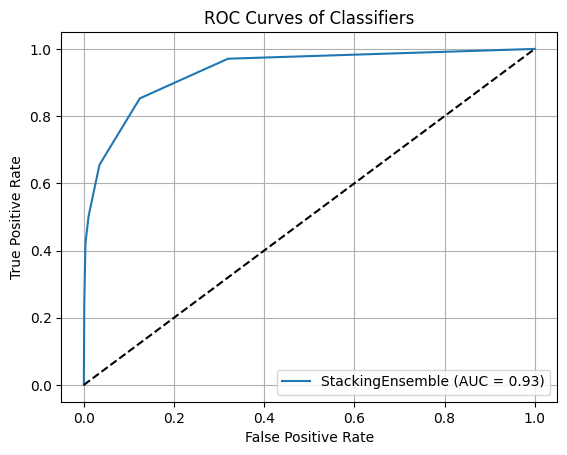

In [98]:
# for name, model in models.items():
y_proba = se.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc_score(y_test, y_proba):.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves of Classifiers')
plt.legend()
plt.grid()
plt.show()

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [05:21:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 46357, number of negative: 46357
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003160 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15043
[LightGBM] [Info] Number of data points in the train set: 92714, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[    0     1     2 ... 92710 92711 92712] [    8    39    75 ... 92700 92707 92713]
[    0     1     2 ... 92711 92712 92713] [    4     6     7 ... 92698 92705 92710]
[    2     4     5 ... 92711 92712 92713] [    0     1     3 ... 92701 92702 92703]
[    0     1     2 ... 92710 92711 92713] [   10    14    16 ... 92691 92708 92712]
[    0     1     3 ... 92710 92712 92713] [    2     5    15 ... 92706 92709 92711]
[    0     1     2 ... 92710 92711 92712] [    8    39    75 ... 92700 92707

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [05:23:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[    0     1     2 ... 92711 92712 92713] [    4     6     7 ... 92698 92705 92710]
[    2     4     5 ... 92711 92712 92713] [    0     1     3 ... 92701 92702 92703]


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [05:23:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[    0     1     2 ... 92710 92711 92713] [   10    14    16 ... 92691 92708 92712]
[    0     1     3 ... 92710 92712 92713] [    2     5    15 ... 92706 92709 92711]


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [05:23:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[    0     1     2 ... 92710 92711 92712] [    8    39    75 ... 92700 92707 92713]


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[    0     1     2 ... 92711 92712 92713] [    4     6     7 ... 92698 92705 92710]


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[    2     4     5 ... 92711 92712 92713] [    0     1     3 ... 92701 92702 92703]


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[    0     1     2 ... 92710 92711 92713] [   10    14    16 ... 92691 92708 92712]


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[    0     1     3 ... 92710 92712 92713] [    2     5    15 ... 92706 92709 92711]


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(

                     accuracy  precision    recall        f1   roc_auc
Logistic Regression  0.651785   0.425385  0.946412  0.586952  0.856152
Decision Tree        0.825923   0.620626  0.859506  0.720789  0.916146
Random Forest        0.891278   0.825331  0.740913  0.780847  0.945540
XGBoost              0.881898   0.872192  0.642358  0.739836  0.940434
LightGBM             0.886832   0.840705  0.699674  0.763733  0.943728
StackingEnsemble     0.884212   0.869780  0.655172  0.747375  0.934305


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/valida

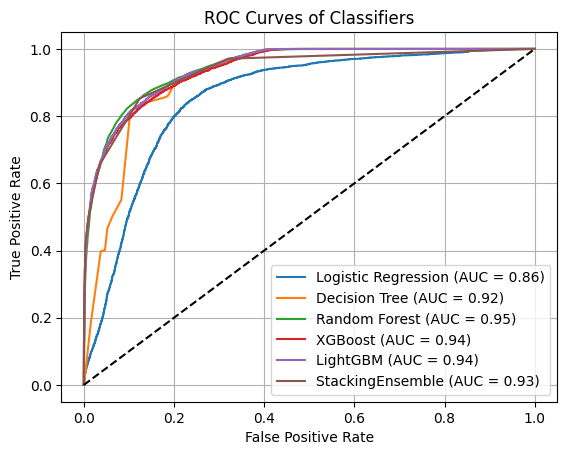

In [101]:
X, X_test, y, y_test = get_train_test_split(df, features_to_keep)

# Train-test split
X_train, y_train = X, y# get_train_test_split(df, features_to_keep)#train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

# Handling imbalance using SMOTE
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# Model training
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(max_depth=6),
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'LightGBM': lgb.LGBMClassifier(),
    'StackingEnsemble': StackingEnsemble()
}

results = {}

for name, model in models.items():
    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_proba)
    }

# Display results
results_df = pd.DataFrame(results).T
# import ace_tools as tools; tools.display_dataframe_to_user(name="Model Performance Comparison", dataframe=results_df)
print(results_df)
# Plot ROC Curves
plt.figure()
for name, model in models.items():
    y_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc_score(y_test, y_proba):.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves of Classifiers')
plt.legend()
plt.grid()
plt.show()


   Unnamed: 0  row_id    user_id   length_mean  start_year_mean  \
0           0      31  522576412  10133.678750        2019.3250   
1           1      53  551695186      5.359195        2019.3620   
2           2      65  561472000      4.885714        2019.0000   
3           3      85  585643355   4175.082759        2019.8966   
4           4     133  520792937      3.325601        2019.3196   

   start_yearday_mean  start_month_mean  start_monthday_mean  start_week_mean  \
0           241.65000          8.400000            16.875000        33.825000   
1           222.05173          7.827586            14.655172        31.448277   
2           297.54285         10.114285            21.000000        43.142857   
3           106.00000          3.931035            17.655172        15.896552   
4           212.86598          7.556701            13.711340        30.989690   

   start_weekday_mean  ...  purchase_latent_factor14  \
0            4.225000  ...                  0.633005  

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [03:10:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 41624, number of negative: 41624
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018690 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 55125
[LightGBM] [Info] Number of data points in the train set: 83248, number of used features: 218
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


                     accuracy  precision    recall        f1   roc_auc
Logistic Regression  0.759878   0.562469  0.797598  0.659709  0.829187
Decision Tree        0.773540   0.577577  0.833797  0.682430  0.882395
Random Forest        0.854647   0.809177  0.656805  0.725072  0.887916
XGBoost              0.852463   0.798362  0.661504  0.723518  0.879689
LightGBM             0.857339   0.791774  0.693526  0.739401  0.889360


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


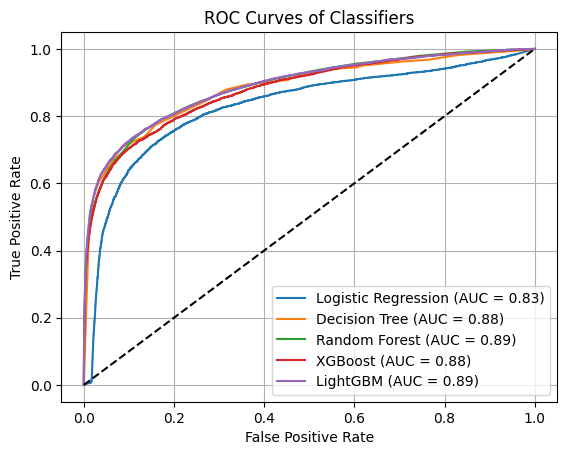

In [ ]:
# Load the dataset
df = pd.read_csv('./data/rees46_churn_data.csv')

# Initial inspection
print(df.head())
print(df.info())
print(df.describe())
print(df['target_event'].value_counts())

# Data preprocessing
# Fill missing values
df.fillna(0, inplace=True)
X, y, X_test, y_test = get_train_test_split(df)
# Feature-target split
# X = df.drop('churn', axis=1)
# y = df['churn']

# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test = scaler.transform(X_test)

# Train-test split
X_train, y_train = X_scaled, y# get_train_test_split(df, features_to_keep)#train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

# Handling imbalance using SMOTE
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# Model training
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(max_depth=6),
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'LightGBM': lgb.LGBMClassifier()
}

results = {}

for name, model in models.items():
    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_proba)
    }

# Display results
results_df = pd.DataFrame(results).T
# import ace_tools as tools; tools.display_dataframe_to_user(name="Model Performance Comparison", dataframe=results_df)
print(results_df)
# Plot ROC Curves
plt.figure()
for name, model in models.items():
    y_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc_score(y_test, y_proba):.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves of Classifiers')
plt.legend()
plt.grid()
plt.show()
